<a href="https://colab.research.google.com/github/owoMarciN/AgileProject/blob/AG-23-EA/SmartStreetLighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install lion-pytorch
!pip install torchvision
!pip install torch_optimizer
!pip install --upgrade ucimlrepo
!pip install optuna
!pip install xgboost
!pip install -U scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.6 MB/s eta 0:00:00


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch_optimizer as toptim

In [ ]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
import itertools
import random
import optuna
import time

from lion_pytorch import Lion
from torch.utils.data import DataLoader, TensorDataset
from optuna.samplers import TPESampler, NSGAIISampler, GridSampler, RandomSampler
from optuna.pruners import HyperbandPruner

In [ ]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

---

## To access the datasets and load them from Google Drive go back to the Main Folder and look for **GoogleDrive.jpg**

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data from file
root_dir = '/content/drive/MyDrive/Colab Notebooks/IntroAI/StreetLight/'

In [ ]:
df = pd.read_csv(root_dir + "smart_lighting_dataset_2024.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/IntroAI/StreetLight/smart_lighting_dataset_2024.csv'

In [ ]:
import pandas as pd

df = pd.read_csv("/content/smart_lighting_dataset_2024.csv")

print(df.shape)
df.head()


(12000, 17)


timestamp  zone_id  ambient_light_lux  motion_detected  \
0  2024-01-01 00:00:00        3               0.00                0   
1  2024-01-01 00:43:00        3              35.78                0   
2  2024-01-01 01:27:00        7               0.00                0   
3  2024-01-01 02:11:00        2               0.00                1   
4  2024-01-01 02:55:00        4               0.00                1   

   temperature_celsius  occupancy_count day_of_week time_of_day  \
0                22.08                7      Monday       Night   
1                19.19                6      Monday       Night   
2                27.78                9      Monday       Night   
3                33.11               16      Monday       Night   
4                27.07               11      Monday       Night   

  weather_condition  special_event_flag  energy_price_per_kwh  \
0            Cloudy                   0                  3.83   
1            Cloudy                   0                  4.61   
2             Clear                   0                  4.21   
3             Foggy                   0                  6.16   
4             Clear                   0                  5.72   

   prev_hour_energy_usage_kwh  traffic_density  avg_pedestrian_speed  \
0                        3.27             26.0                  4.54   
1                        1.50             18.9                  2.42   
2                        2.51             27.6                  2.85   
3                        0.34             23.1                  2.45   
4                        1.52             26.4                  3.49   

   adjusted_light_intensity  energy_consumption_kwh  lighting_action_class  
0                     54.40                   1.144                      0  
1                     89.75                   2.069                      1  
2                     82.25                   1.687                      1  
3                     72.57                   1.631                      1  
4                     78.79                   1.737                      1

In [ ]:
print(df.describe())

           zone_id  ambient_light_lux  motion_detected  temperature_celsius  \
count  12000.00000       12000.000000     12000.000000         12000.000000   
mean       6.53425        3708.629288         0.284083            24.964518   
std        3.48035        4656.283063         0.450996             6.260797   
min        1.00000           0.000000         0.000000           -15.870000   
25%        4.00000          55.565000         0.000000            20.970000   
50%        7.00000        2031.855000         0.000000            24.970000   
75%       10.00000        7011.792500         1.000000            29.082500   
max       12.00000      105403.500000         1.000000            64.860000   

       occupancy_count  special_event_flag  energy_price_per_kwh  \
count     12000.000000        12000.000000          12000.000000   
mean          8.557167            0.008583              5.034449   
std           8.273770            0.092252              1.272504   
min           0.

In [ ]:

# changing the 'timestamp' column to an datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
# Splitting the datetime object
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday   # 0 = Monday
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [ ]:
# Droping the timestap column after splitting it
df = df.drop(columns=['timestamp'])

# We won't use the binary classification here. We want to predict a regression quantity
df = df.drop(columns=['lighting_action_class'])

# Droping redundat columns
df = df.drop(columns=['day_of_week', 'time_of_day'])

In [ ]:
# One-hot encoding which changes a category into a set of independent binary signals.
df = pd.get_dummies(df, columns=['zone_id', 'weather_condition'], drop_first=True)
df

ambient_light_lux  motion_detected  temperature_celsius  \
0                   0.00                0                22.08   
1                  35.78                0                19.19   
2                   0.00                0                27.78   
3                   0.00                1                33.11   
4                   0.00                1                27.07   
...                  ...              ...                  ...   
11995               0.00                0                24.84   
11996             170.09                0                20.16   
11997             176.03                0                28.53   
11998             375.50                1                34.16   
11999             408.41                0                18.23   

       occupancy_count  special_event_flag  energy_price_per_kwh  \
0                    7                   0                  3.83   
1                    6                   0                  4.61   
2                    9                   0                  4.21   
3                   16                   0                  6.16   
4                   11                   0                  5.72   
...                ...                 ...                   ...   
11995               13                   0                  4.19   
11996                5                   0                  3.95   
11997                8                   0                  3.02   
11998               11                   0                  3.94   
11999               15                   0                  6.09   

       prev_hour_energy_usage_kwh  traffic_density  avg_pedestrian_speed  \
0                            3.27             26.0                  4.54   
1                            1.50             18.9                  2.42   
2                            2.51             27.6                  2.85   
3                            0.34             23.1                  2.45   
4                            1.52             26.4                  3.49   
...                           ...              ...                   ...   
11995                        3.96             15.6                  4.49   
11996                        2.24             20.5                  1.76   
11997                        4.14             35.3                  3.53   
11998                        3.82             30.0                  2.52   
11999                        1.84             28.0                  2.56   

       adjusted_light_intensity  ...  zone_id_6  zone_id_7  zone_id_8  \
0                         54.40  ...      False      False      False   
1                         89.75  ...      False      False      False   
2                         82.25  ...      False       True      False   
3                         72.57  ...      False      False      False   
4                         78.79  ...      False      False      False   
...                         ...  ...        ...        ...        ...   
11995                     88.85  ...      False      False      False   
11996                     89.41  ...      False       True      False   
11997                     93.44  ...       True      False      False   
11998                     69.08  ...      False      False      False   
11999                     65.55  ...      False      False      False   

       zone_id_9  zone_id_10  zone_id_11  zone_id_12  \
0          False       False       False       False   
1          False       False       False       False   
2          False       False       False       False   
3          False       False       False       False   
4          False       False       False       False   
...          ...         ...         ...         ...   
11995      False       False       False       False   
11996      False       False       False       False   
11997      False       False       False       False   
11998      False       False       False       

In [ ]:
# Preserving the DataFrame for Fuzzy Rules later
df_original = df.copy()

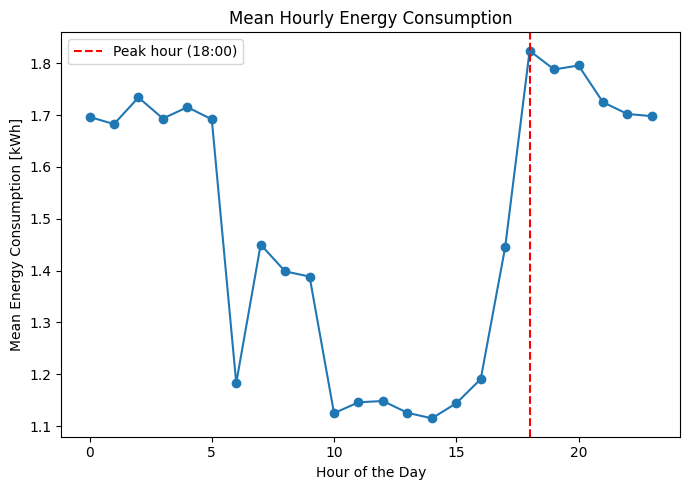

In [ ]:
plt.figure(figsize=(7, 5))
hourly_mean = (
    df
    .groupby('hour', as_index=False)['energy_consumption_kwh']
    .mean()
)

plt.plot(hourly_mean["hour"], hourly_mean["energy_consumption_kwh"], marker="o")
peak_hour = hourly_mean.loc[hourly_mean["energy_consumption_kwh"].idxmax(), "hour"]
plt.axvline(peak_hour, linestyle="--", color="red", label=f"Peak hour ({peak_hour}:00)")
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Energy Consumption [kWh]')
plt.title('Mean Hourly Energy Consumption')
plt.tight_layout()
plt.legend()
plt.show()

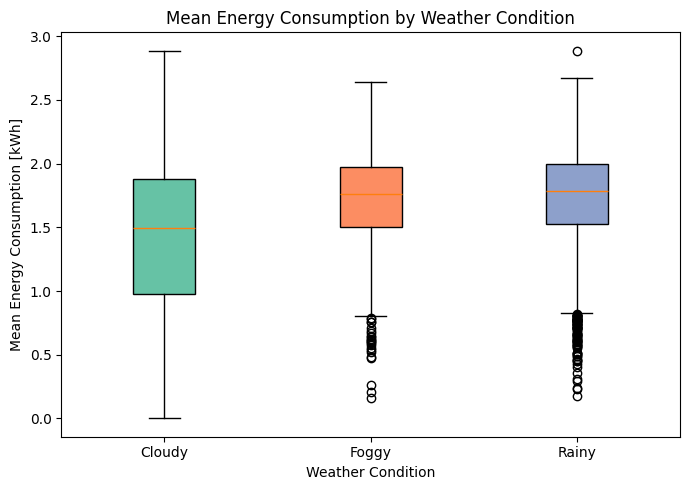

In [ ]:
weather_cols = [c for c in df.columns if c.startswith("weather_condition_")]
df_weather = df.copy()

df_weather["Weather"] = (
    df_weather[weather_cols]
    .idxmax(axis=1)
    .str.replace("weather_condition_", "")
)

weather_order = df_weather["Weather"].unique()
data = [
    df_weather.loc[df_weather["Weather"] == w, "energy_consumption_kwh"]
    for w in weather_order
]

plt.figure(figsize=(7, 5))

bp = plt.boxplot(
    data,
    patch_artist=True,
    tick_labels=weather_order,
    showfliers=True
)

colors = plt.cm.Set2.colors  # professional, colorblind-safe
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

plt.xlabel("Weather Condition")
plt.ylabel("Mean Energy Consumption [kWh]")
plt.title("Mean Energy Consumption by Weather Condition")
plt.tight_layout()
plt.show()


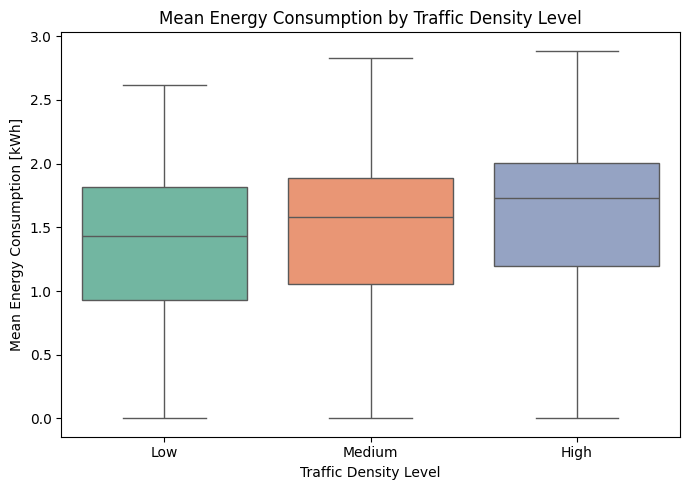

In [ ]:
df["traffic_density_bin"] = pd.qcut(
    df["traffic_density"],
    q=3,
    labels=["Low", "Medium", "High"]
)

plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df,
    x="traffic_density_bin",
    y="energy_consumption_kwh",
    palette="Set2",
    hue="traffic_density_bin"
)

plt.xlabel("Traffic Density Level")
plt.ylabel("Mean Energy Consumption [kWh]")
plt.title("Mean Energy Consumption by Traffic Density Level")
plt.tight_layout()
plt.show()

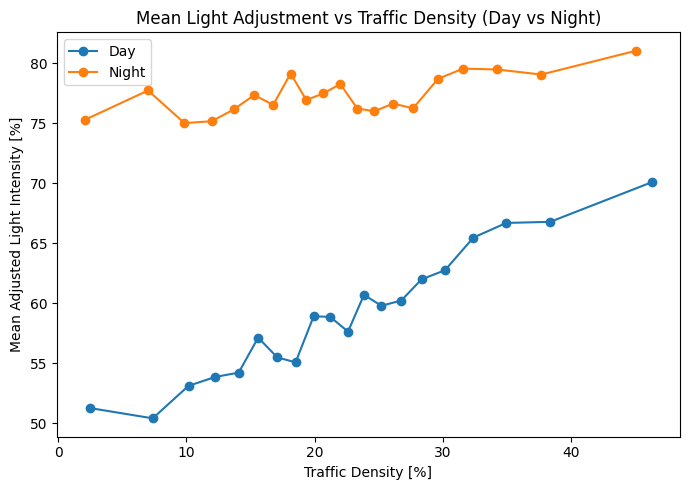

In [ ]:
df["day_period"] = np.where(
    (df["hour"] >= 7) & (df["hour"] < 19),
    "Day",
    "Night"
)

plt.figure(figsize=(7, 5))

for period in ["Day", "Night"]:
    subset = df[df["day_period"] == period]
    bins = pd.qcut(subset["traffic_density"], q=20, duplicates="drop")
    mean_light = subset.groupby(bins, observed=False)["adjusted_light_intensity"].mean()
    mean_density = subset.groupby(bins, observed=False)["traffic_density"].mean()

    plt.plot(
        mean_density,
        mean_light,
        marker="o",
        label=period
    )

plt.xlabel("Traffic Density [%]")
plt.ylabel("Mean Adjusted Light Intensity [%]")
plt.title("Mean Light Adjustment vs Traffic Density (Day vs Night)")
plt.legend()
plt.tight_layout()
plt.show()

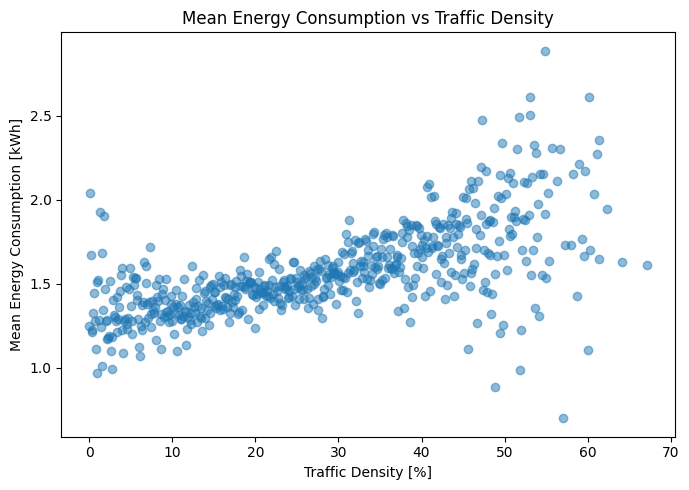

In [ ]:
traffic_energy_mean = (df.groupby("traffic_density", as_index=False)['energy_consumption_kwh'].mean())

plt.figure(figsize=(7, 5))
plt.scatter(traffic_energy_mean["traffic_density"], traffic_energy_mean["energy_consumption_kwh"], alpha=0.5)

plt.xlabel("Traffic Density [%]")
plt.ylabel("Mean Energy Consumption [kWh]")
plt.title("Mean Energy Consumption vs Traffic Density")
plt.tight_layout()
plt.show()


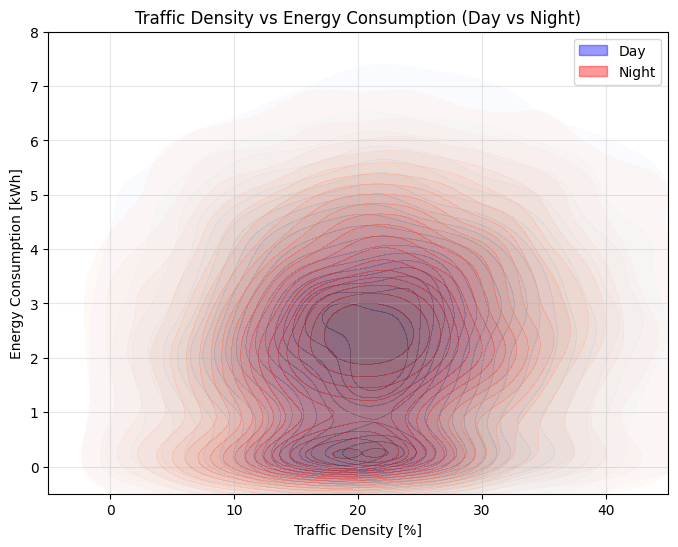

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8,6))

# Day
subset_day = df[df["day_period"] == "Day"]
sns.kdeplot(
    x=subset_day["traffic_density"],
    y=subset_day["prev_hour_energy_usage_kwh"],
    fill=True,
    cmap="Blues",
    alpha=0.4,
    thresh=0.05,
    levels=20,
    ax=ax
)

# Night
subset_night = df[df["day_period"] == "Night"]
sns.kdeplot(
    x=subset_night["traffic_density"],
    y=subset_night["prev_hour_energy_usage_kwh"],
    fill=True,
    cmap="Reds",
    alpha=0.4,
    thresh=0.05,
    levels=20,
    ax=ax
)

ax.set_xlim(-5, 45)
ax.set_ylim(-0.5, 8)
ax.set_xlabel("Traffic Density [%]")
ax.set_ylabel("Energy Consumption [kWh]")
ax.set_title("Traffic Density vs Energy Consumption (Day vs Night)")

# Create proxy artists for the legend
blue_patch = mpatches.Patch(color='blue', label='Day', alpha=0.4)
red_patch = mpatches.Patch(color='red', label='Night', alpha=0.4)
ax.legend(handles=[blue_patch, red_patch])

ax.grid(alpha=0.3)
plt.show()

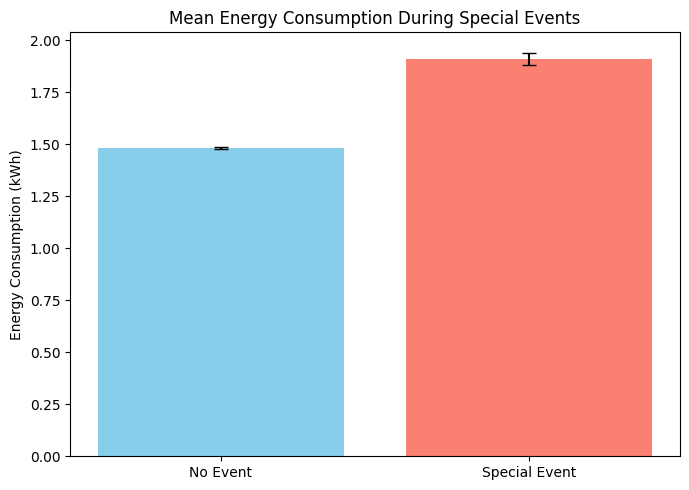

In [ ]:
event_0 = df[df["special_event_flag"] == 0]["energy_consumption_kwh"]
event_1 = df[df["special_event_flag"] == 1]["energy_consumption_kwh"]

means = [event_0.mean(), event_1.mean()]
sems = [event_0.sem(), event_1.sem()]

plt.figure(figsize=(7, 5))
plt.bar(
    ["No Event", "Special Event"],
    means,
    yerr=sems,
    capsize=5,
    color=["skyblue", "salmon"]
)

plt.ylabel("Energy Consumption (kWh)")
plt.title("Mean Energy Consumption During Special Events")
plt.tight_layout()
plt.show()

---

### Checking the skewness of some of the features. Skewness matters  because many algorithms assume normal (symmetric) distribution, causing skewed data to bias models, distort relationships, increase training time, and make feature importance misleading, requiring transformations (like log transform) to improve performance.

---

In [ ]:
# List of skewed features to plot
features = ['ambient_light_lux', 'occupancy_count', 'prev_hour_energy_usage_kwh', 'energy_consumption_kwh', 'adjusted_light_intensity']

# Compute skewness
print("Skewness:")
for f in features:
    skew_val = df[f].skew()
    print(f"{f}: {skew_val:.2f}")

Skewness:
ambient_light_lux: 5.72
occupancy_count: 11.76
prev_hour_energy_usage_kwh: 0.43
energy_consumption_kwh: -0.35
adjusted_light_intensity: -0.50


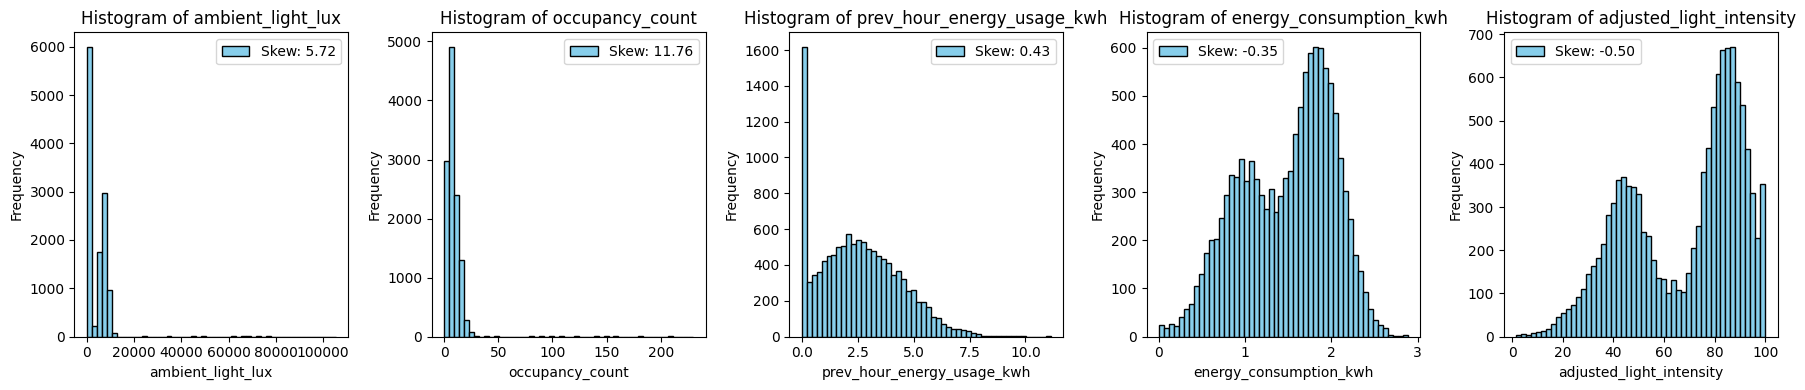

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(18, 4))

for i, f in enumerate(features):
    skew_val = df[f].skew()
    axes[i].hist(df[f], bins=50, color='skyblue', edgecolor='k', label=f"Skew: {skew_val:.2f}")
    axes[i].set_title(f"Histogram of {f}")
    axes[i].set_xlabel(f)
    axes[i].legend()
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
# Apply log1p to highly skewed numeric features
df['ambient_light_lux'] = np.log1p(df['ambient_light_lux'])
df['occupancy_count'] = np.log1p(df['occupancy_count'])

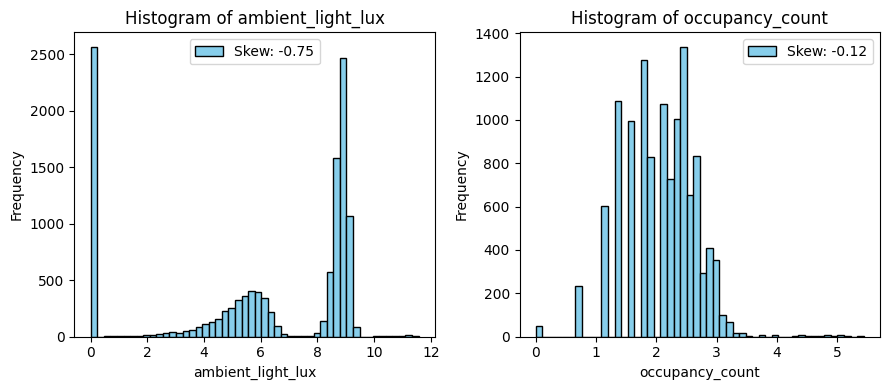

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features)-3, figsize=(9, 4))

for i, f in enumerate(features[:2]):
    skew_val = df[f].skew()
    axes[i].hist(df[f], bins=50, color='skyblue', edgecolor='k', label=f"Skew: {skew_val:.2f}")
    axes[i].set_title(f"Histogram of {f}")
    axes[i].set_xlabel(f)
    axes[i].legend()
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

---

### Choosing the **target_value** and prepering the X, y input DataFrames

---

In [ ]:
target_feature = 'adjusted_light_intensity'
# X as a DataFrame to retain column names for fuzzy rules later
X_df_features = df.drop(columns=[target_feature])

# Target
y = df[target_feature]

--------------------------------------------------------------------------------
##Creating a **Pairplot** of the dataset.
--------------------------------------------------------------------------------

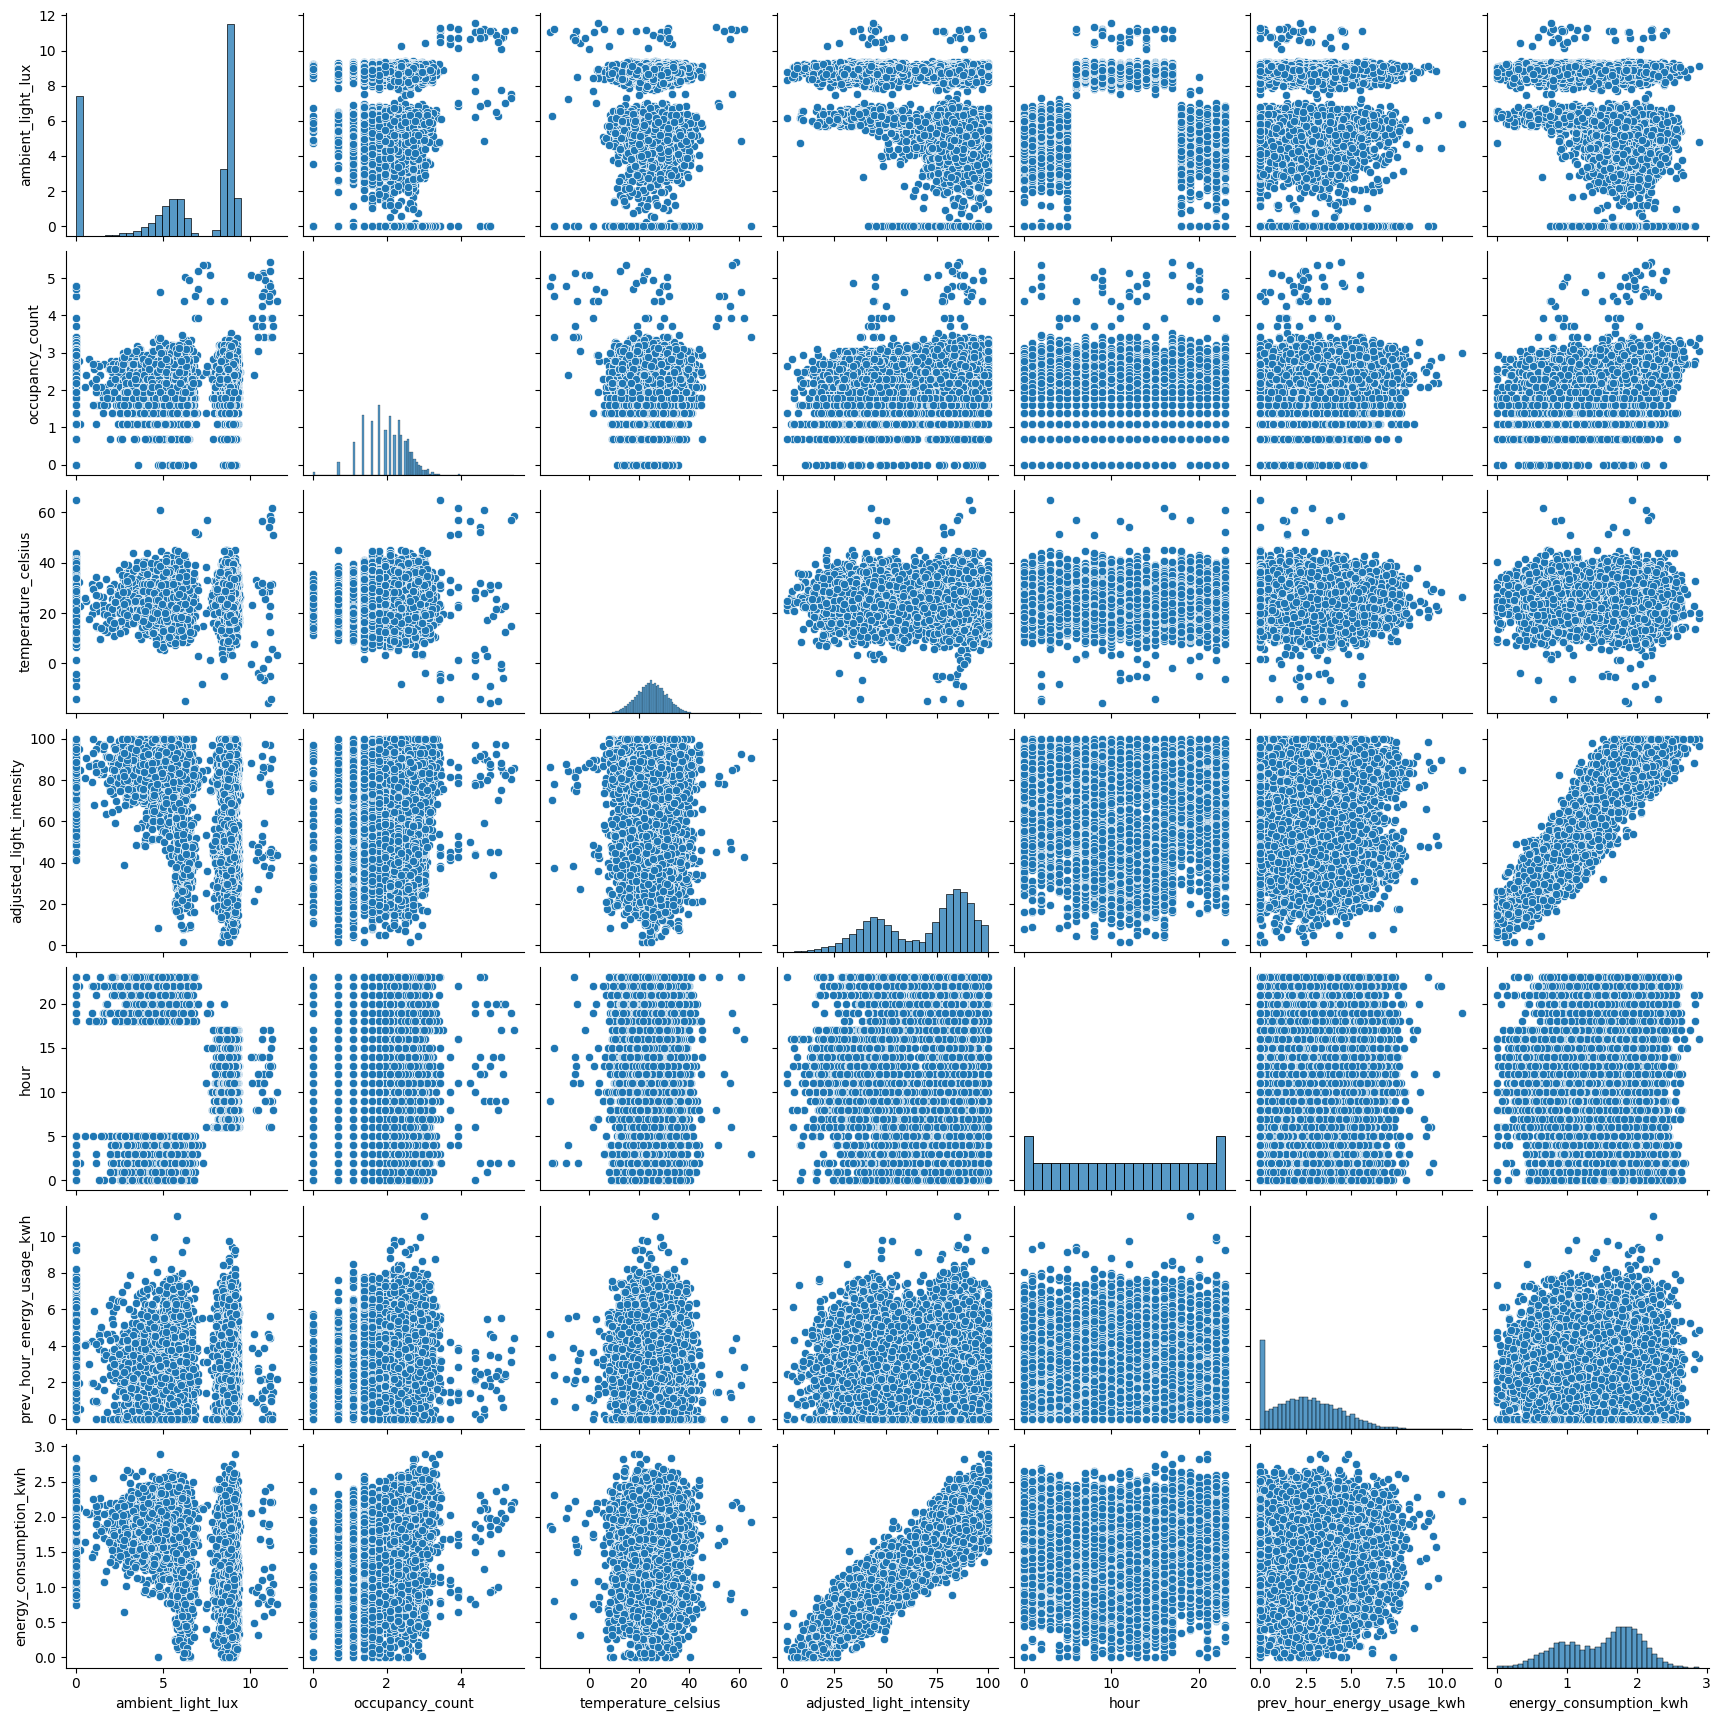

In [ ]:
plot_features = [
    'ambient_light_lux',
    'occupancy_count',
    'temperature_celsius',
    'adjusted_light_intensity',
    'hour',
    'prev_hour_energy_usage_kwh',
    'energy_consumption_kwh'
]

sns.pairplot(df[plot_features])
plt.show()

--------------------------------------------------------------------------------
##Creating a **Correlation HeatMap** of the dataset.
--------------------------------------------------------------------------------

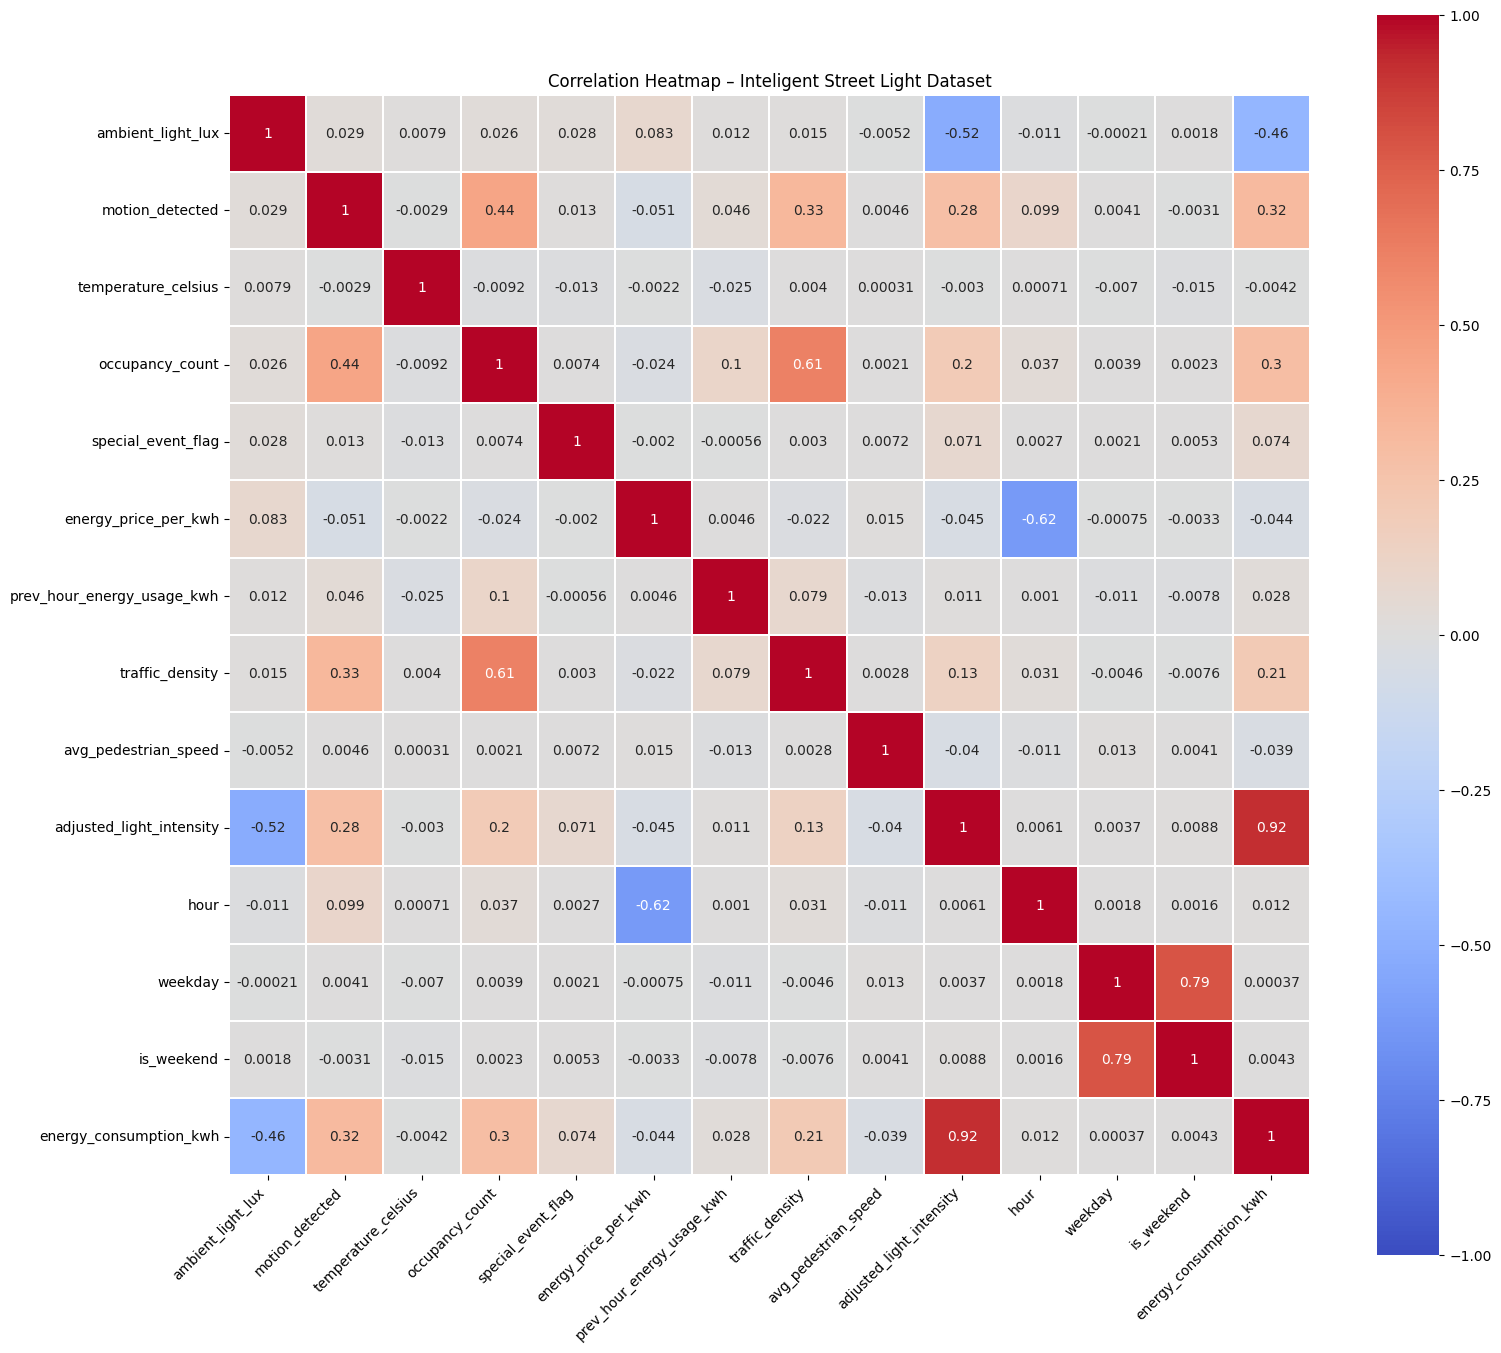

In [ ]:
heatmap_features = [
    'ambient_light_lux',
    'motion_detected',
    'temperature_celsius',
    'occupancy_count',
    'special_event_flag',
    'energy_price_per_kwh',
    'prev_hour_energy_usage_kwh',
    'traffic_density',
    'avg_pedestrian_speed',
    'adjusted_light_intensity',
    'hour',
    'weekday',
    'is_weekend',
    'energy_consumption_kwh'
]

corr = df[heatmap_features].select_dtypes(include='number').corr(method='pearson')

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.3,
    square=True
)

plt.title("Correlation Heatmap – Inteligent Street Light Dataset")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
##Creating a **Boxplot** of the normalized data of the dataset.
--------------------------------------------------------------------------------

In [ ]:
boxplot_features = X.columns.tolist()
boxplot_features = boxplot_features[0:14]

# Create DataFrame with X features
X_df = pd.DataFrame(X, columns=boxplot_features)

X_df[target_feature] = y.values
boxplot_features.append(target_feature)

NameError: name 'X' is not defined

---

## Train, split, test, and normalization of the dataset

---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import torch

# Split the unscaled DataFrame features and target
X_train_orig, X_test_orig, y_train_split, y_test_split = train_test_split(
    X_df_features, y, test_size=0.2, random_state=42
)

# Store df_test for simple fuzzy rules (contains original, unscaled feature values as a DataFrame)
df_test = X_test_orig.copy()

# Identify numeric and categorical columns
num_cols = X_train_orig.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_orig.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocess: scale numeric, one-hot encode categorical
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

# Transform to numeric matrix
Xtr_scaled_np = pre.fit_transform(X_train_orig)
Xte_scaled_np = pre.transform(X_test_orig)

# Convert sparse matrices to dense if needed (PyTorch needs dense)
if hasattr(Xtr_scaled_np, "toarray"):
    Xtr_scaled_np = Xtr_scaled_np.toarray()
    Xte_scaled_np = Xte_scaled_np.toarray()

# Convert scaled NumPy arrays to PyTorch Tensors for MLP
Xtr = torch.tensor(Xtr_scaled_np, dtype=torch.float32)
Xte = torch.tensor(Xte_scaled_np, dtype=torch.float32)

# Convert y splits to PyTorch Tensors
ytr = torch.tensor(y_train_split.to_numpy(dtype=float), dtype=torch.float32)
yte = torch.tensor(y_test_split.to_numpy(dtype=float), dtype=torch.float32)

print("Xtr/Xte:", Xtr.shape, Xte.shape)
print("ytr/yte:", ytr.shape, yte.shape)


Xtr/Xte: torch.Size([9600, 47]) torch.Size([2400, 47])
ytr/yte: torch.Size([9600]) torch.Size([2400])


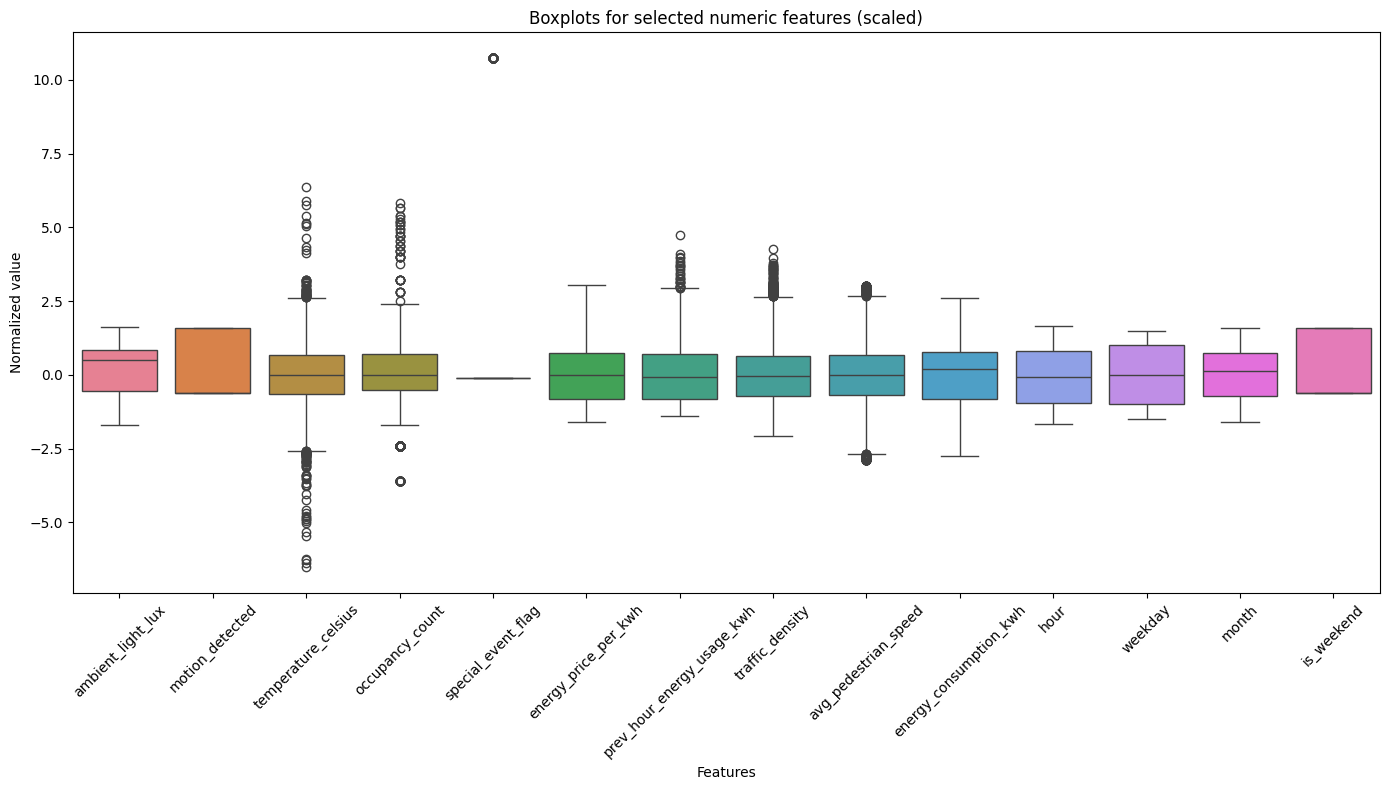

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1) wybierz dane do boxplotów (tu: Twoje cechy wejściowe)
X_df = X_df_features.copy()

# 2) weź tylko numeryczne kolumny (żeby scaler i boxplot działały)
num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()

# jeśli chcesz ograniczyć liczbę kolumn (czytelność):
num_cols = num_cols[:14]

X_num = X_df[num_cols].copy()

# 3) skalowanie numerycznych
X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X_num),
    columns=num_cols
)

# 4) boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=X_scaled)
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Normalized value")
plt.title("Boxplots for selected numeric features (scaled)")
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
##Simple **MLP** implementation with **Hyper-paramenters**
--------------------------------------------------------------------------------

In [ ]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_dim=28, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return F.softplus(self.net(x))

def get_optimizer(name, params, lr, momentum=0.9, weight_decay=0.0):
    """Return PyTorch optimizer instance based on name."""
    name = name.lower()
    # SGD variants
    if name == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Adaptive methods
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "amsgrad":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay, amsgrad=True)
    if name == "adagrad":
        return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    if name == "adadelta":
        return optim.Adadelta(params, lr=lr, weight_decay=weight_decay)

    # Other advanced optimizers (requires torch_optimizer)
    if name == "nadam":
        return optim.NAdam(params, lr=lr, weight_decay=weight_decay)
    if name == "lion":
        return Lion(params, lr=lr, weight_decay=weight_decay)

    # RMSprop
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    raise ValueError(f"Unknown optimizer: {name}")

In [ ]:
def train_and_eval(opt_name, Xtr, Xte, ytr, yte, hparams, n_epochs=1000):
    start_time = time.time()

    in_dim = Xtr.shape[1]  # ← TU przenosimy to z argumentów
    model = MLP(in_dim=in_dim, hidden=hparams["hidden_size"])

    optimizer = get_optimizer(
        opt_name,
        model.parameters(),
        lr=hparams["lr"],
        momentum=hparams["momentum"],
        weight_decay=hparams["weight_decay"]
    )

    criterion = nn.PoissonNLLLoss(log_input=False)
    losses = []

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    best_loss = float("inf")
    patience_counter = 0
    early_stop_patience = 10

    for epoch in range(n_epochs):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb).squeeze()
            loss = criterion(outputs, yb.float())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            break

        epochs_run = epoch + 1

    model.eval()
    with torch.no_grad():
        y_pred = model(Xte).cpu().numpy().squeeze()

    elapsed_time = time.time() - start_time

    metrics = {
        "RMSE": np.sqrt(mean_squared_error(yte, y_pred)),
        "MAE": mean_absolute_error(yte, y_pred),
        "R2": r2_score(yte, y_pred),
        "runtime": elapsed_time,
        "epochs": epochs_run
    }

    return metrics, losses, y_pred


---

Example usage of the MLP baseline

---

In [ ]:

hp = {"lr": 0.002, "momentum": 0.9, "hidden_size": 32, "weight_decay": 0.0, "batch_size": 16}

In [ ]:
metrics, losses, y_pred = train_and_eval("lion", Xtr, Xte, ytr, yte, hp)
print(f"RMSE:    {metrics['RMSE']:.4f}")
print(f"MAE:     {metrics['MAE']:.4f}")
print(f"R2:      {metrics['R2']:.4f}")
print(f"Runtime: {metrics['runtime']:.4f} sec")

RMSE:    7.6011
MAE:     5.9072
R2:      0.8852
Runtime: 79.3442 sec


---

### Some additional plots

---

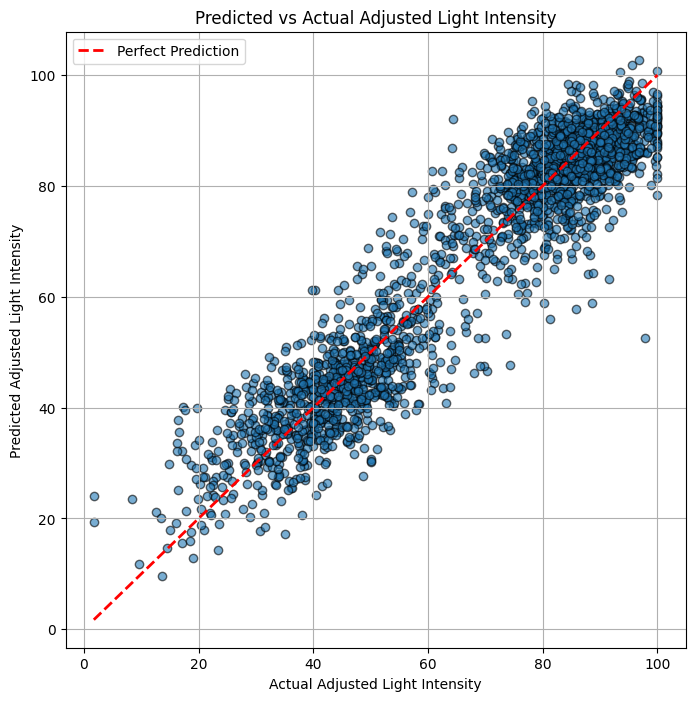

In [ ]:
y_true = yte.numpy() if isinstance(yte, torch.Tensor) else yte

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Adjusted Light Intensity')
plt.ylabel('Predicted Adjusted Light Intensity')
plt.title('Predicted vs Actual Adjusted Light Intensity')
plt.legend()
plt.grid(True)
plt.show()

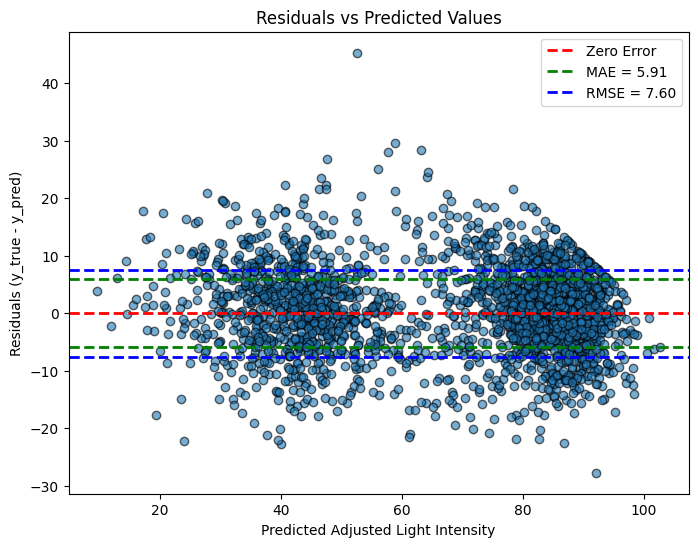

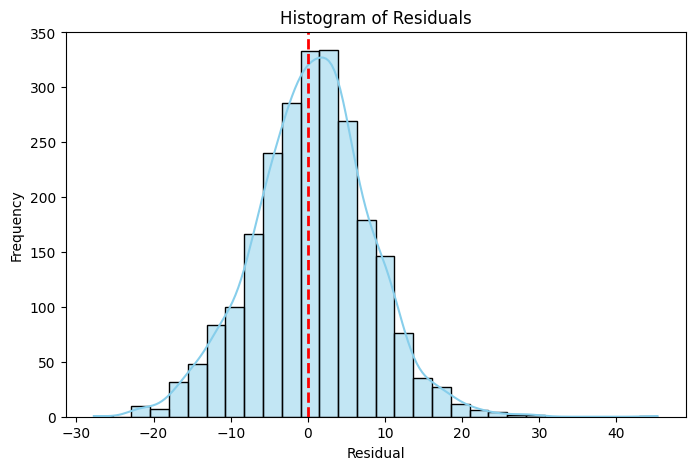

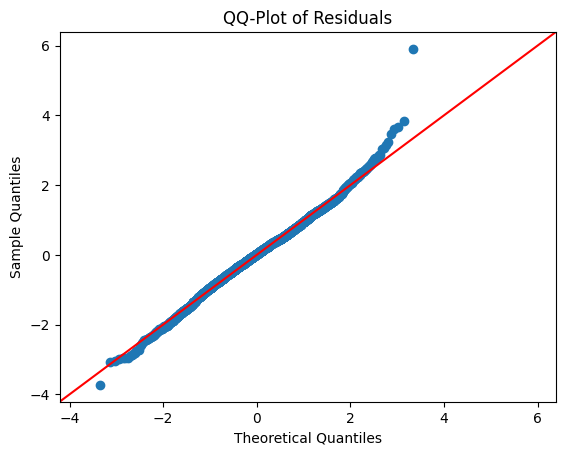

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure y_true is a 1D numpy array
y_true = yte.numpy().flatten() if isinstance(yte, torch.Tensor) else yte.flatten()
# Ensure y_pred is a 1D numpy array
y_pred = y_pred.flatten()

residuals = y_true - y_pred

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2, label='Zero Error')
plt.axhline(mae, color='g', linestyle='--', lw=2, label=f'MAE = {mae:.2f}')
plt.axhline(-mae, color='g', linestyle='--', lw=2)
plt.axhline(rmse, color='b', linestyle='--', lw=2, label=f'RMSE = {rmse:.2f}')
plt.axhline(-rmse, color='b', linestyle='--', lw=2)
plt.xlabel('Predicted Adjusted Light Intensity')
plt.ylabel('Residuals (y_true - y_pred)')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()

# Residual histogram
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Optional: QQ-plot to check normality/skewness
import scipy.stats as stats
import statsmodels.api as sm

sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ-Plot of Residuals')
plt.show()

---

### Testing which optimizers gets the best results. The best are:
- **Lion**
- Adam

---

In [ ]:
optimizers = ["sgd", "momentum", "adam", "amsgrad", "adagrad", "adadelta", "nadam", "lion", "rmsprop"]

results = []

for opt_name in optimizers:
    metrics, losses, y_pred = train_and_eval(opt_name, Xtr, Xte, ytr, yte, hp)
    results.append({
        "Optimizer": opt_name,
        "RMSE": metrics["RMSE"],
        "MAE": metrics["MAE"],
        "R2": metrics["R2"],
        "Runtime_sec": metrics["runtime"]
    })

df_results = pd.DataFrame(results)

print(df_results)

  Optimizer        RMSE       MAE         R2  Runtime_sec
0       sgd    7.505244  5.870110   0.888073   348.861181
1  momentum    8.211246  6.494609   0.866025    95.776306
2      adam    7.516205  5.856816   0.887746    84.415761
3   amsgrad    7.400953  5.754874   0.891162   174.966151
4   adagrad    8.337635  6.639002   0.861869   689.291551
5  adadelta    7.992338  6.344404   0.873073   769.191633
6     nadam    7.534742  5.881027   0.887192   156.170396
7      lion  200.484803  9.857101 -78.867096    51.284334
8   rmsprop    7.510313  5.895343   0.887922    63.566510


---

### Testing the performance of some scikit-learn library baselines. The best are:
- **XGB**
- GradientBoosting

---

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Define all models
models = [
    ("XGB", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,

    )),
    ("Ridge", Ridge(alpha=1.0)),
    ("Lasso", Lasso(alpha=0.01)),
    ("ElasticNet", ElasticNet(alpha=0.01, l1_ratio=0.5)),
    ("RandomForest", RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        n_jobs=-1,

    )),
    ("GradientBoosting", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,

    )),
]

In [ ]:
def model_eval(model, Xtr, Xte, ytr, yte, param = {}):
    ytr = ytr.ravel()
    yte = yte.ravel()

    start_time = time.time()
    model.fit(Xtr, ytr)
    elapsed_time = time.time() - start_time

    y_pred = model.predict(Xte)

    metrics = {
        "RMSE": np.sqrt(mean_squared_error(yte, y_pred)),
        "MAE": mean_absolute_error(yte, y_pred),
        "R2": r2_score(yte, y_pred),
        "Runtime": elapsed_time
    }
    return metrics

In [ ]:
results_list = []

for name, model in models:
    result = {"RMSE": [], "MAE": [], "R2": [], "Runtime": []}

    for _ in range(20):  # 20 runs
        metrics = model_eval(model, Xtr, Xte, ytr, yte)
        result["RMSE"].append(metrics["RMSE"])
        result["MAE"].append(metrics["MAE"])
        result["R2"].append(metrics["R2"])
        result["Runtime"].append(metrics["Runtime"])

    results_list.append({
        "Model": name,
        "RMSE": f"{np.mean(result['RMSE']):.4f} ± {np.std(result['RMSE']):.4f}",
        "MAE": f"{np.mean(result['MAE']):.4f} ± {np.std(result['MAE']):.4f}",
        "R2": f"{np.mean(result['R2']):.4f} ± {np.std(result['R2']):.4f}",
        "Runtime_sec": f"{np.mean(result['Runtime']):.4f} ± {np.std(result['Runtime']):.4f} sec"
    })

df_results = pd.DataFrame(results_list)
print(df_results)

              Model             RMSE              MAE               R2  \
0               XGB  7.2282 ± 0.0000  5.6059 ± 0.0000  0.8962 ± 0.0000   
1             Ridge  8.3289 ± 0.0000  6.6211 ± 0.0000  0.8622 ± 0.0000   
2             Lasso  8.3339 ± 0.0000  6.6259 ± 0.0000  0.8620 ± 0.0000   
3        ElasticNet  8.3310 ± 0.0000  6.6244 ± 0.0000  0.8621 ± 0.0000   
4      RandomForest  7.2678 ± 0.0060  5.5832 ± 0.0046  0.8950 ± 0.0002   
5  GradientBoosting  7.2255 ± 0.0005  5.5754 ± 0.0004  0.8963 ± 0.0000   

            Runtime_sec  
0   0.6715 ± 0.1951 sec  
1   0.0082 ± 0.0024 sec  
2   0.0165 ± 0.0022 sec  
3   0.0405 ± 0.0023 sec  
4  18.3577 ± 0.5630 sec  
5  10.7758 ± 0.2566 sec  


--------------------------------------------------------------------------------
#**Dimension Reduction Techniques**
--------------------------------------------------------------------------------

In [ ]:
# Best optimizer
best_opt = "lion"

In [ ]:

# As for now this function is really clunky
# idk if we use it for the final testing
def kmeans_features(X_train, X_test, n_clusters):
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto")

    kmeans.fit(X_train)

    # Transformation train/test (distances to centroids)
    X_train_km = kmeans.transform(X_train).astype("float32")
    X_test_km = kmeans.transform(X_test).astype("float32")

    # Number of clusters
    n_components = n_clusters

    return X_train_km, X_test_km, n_components

In [ ]:
Xtr_km, Xte_km, n_clusters = kmeans_features(Xtr_scaled_np, Xte_scaled_np, n_clusters=4)

Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

metrics, losses, y_pred = train_and_eval(
    opt_name=best_opt,
    Xtr=Xtr_km,
    Xte=Xte_km,
    ytr=ytr,
    yte=yte,
    hparams=hp,
    n_epochs=1000
)
metrics


{'RMSE': np.float64(16.865333783906504),
 'MAE': 13.468481063842773,
 'R2': 0.43480950593948364,
 'runtime': 20.641194820404053,
 'epochs': 18}

In [ ]:
def pca_features(X_train, X_test, var_threshold=0.95):
    # PCA
    pca = PCA(n_components=var_threshold)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    return X_train_pca, X_test_pca, n_components

In [ ]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr_scaled_np, Xte_scaled_np, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

metrics, losses, y_pred = train_and_eval(
    opt_name=best_opt,
    Xtr=Xtr_pca,
    Xte=Xte_pca,
    ytr=ytr,
    yte=yte,
    hparams=hp,
    n_epochs=1000
)
metrics


{'RMSE': np.float64(7.763116381463596),
 'MAE': 6.078573226928711,
 'R2': 0.880249559879303,
 'runtime': 73.56926202774048,
 'epochs': 101}

In [ ]:
class SupervisedAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=8):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottleneck_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

        self.regressor = nn.Linear(bottleneck_dim, 1)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.regressor(z)
        return x_hat, y_hat

    def encode(self, x):
        return self.encoder(x)

In [ ]:
def autoencoder_features(X_train, X_test, y_train, epochs=300, lr=1e-2, alpha=0.7):
    """alpha: weight for reconstruction loss (1-alpha for regression)"""
    input_dim = X_train.shape[1]
    model = SupervisedAutoencoder(input_dim)

    opt = optim.Adam(model.parameters(), lr=lr)
    recon_loss = nn.SmoothL1Loss()
    reg_loss = nn.SmoothL1Loss()

    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        x, y = model(X_train)
        loss = (
            alpha * recon_loss(x, X_train) +
            (1 - alpha) * reg_loss(y.squeeze(), y_train)
        )
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        Z_train = model.encode(X_train)
        Z_test  = model.encode(X_test)

    return Z_train, Z_test

In [ ]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, ytr)

metrics, losses, y_pred = train_and_eval(
    opt_name=best_opt,
    Xtr=Xtr_ae,
    Xte=Xte_ae,
    ytr=ytr,
    yte=yte,
    hparams=hp,
    n_epochs=1000
)
metrics
print("Xtr_ae shape:", Xtr_ae.shape)
print("Xte_ae shape:", Xte_ae.shape)


Xtr_ae shape: torch.Size([9600, 8])
Xte_ae shape: torch.Size([2400, 8])


---

### Plotting the clusters of each technique

---

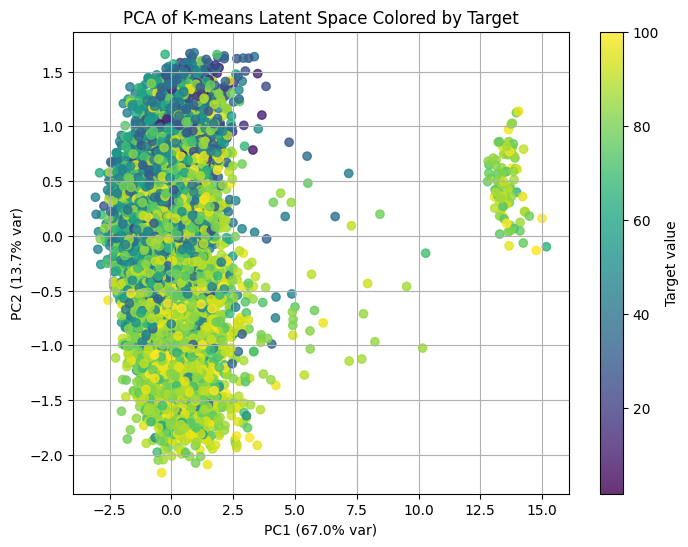

In [ ]:
# Ensure NumPy arrays
if isinstance(Xtr_km, torch.Tensor):
    Xtr_km_np = Xtr_km.detach().cpu().numpy()
else:
    Xtr_km_np = Xtr_km

ytr_np = ytr.detach().cpu().numpy().ravel() if isinstance(ytr, torch.Tensor) else ytr.ravel()

# PCA to 2D
pca_2d = PCA(n_components=2)
Xtr_km_pca = pca_2d.fit_transform(Xtr_km_np)

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Xtr_km_pca[:, 0],
    Xtr_km_pca[:, 1],
    c=ytr_np,
    cmap="viridis",
    alpha=0.8
)

plt.colorbar(sc, label="Target value")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of K-means Latent Space Colored by Target")
plt.grid(True)
plt.show()

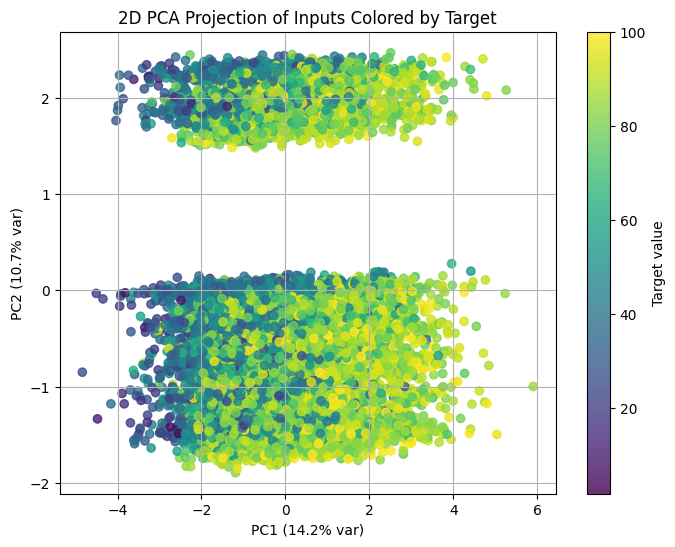

In [ ]:
# Ensure NumPy arrays
ytr_np = ytr.numpy().ravel()
Xtr_np = Xtr_pca if isinstance(Xtr_pca, np.ndarray) else Xtr_pca.detach().cpu().numpy()

# PCA to 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_np)

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Xtr_pca_2d[:, 0],
    Xtr_pca_2d[:, 1],
    c=ytr_np,
    cmap="viridis",
    alpha=0.8
)

plt.colorbar(sc, label="Target value")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("2D PCA Projection of Inputs Colored by Target")
plt.grid(True)
plt.show()

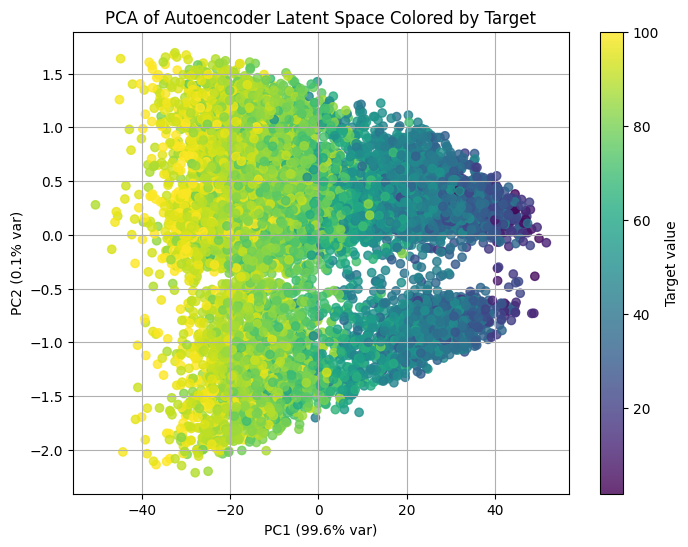

In [ ]:
# Ensure NumPy arrays
if isinstance(Xtr_ae, torch.Tensor):
    Xtr_ae_np = Xtr_ae.detach().cpu().numpy()
else:
    Xtr_ae_np = Xtr_ae

ytr_np = ytr.detach().cpu().numpy().ravel() if isinstance(ytr, torch.Tensor) else ytr.ravel()

# PCA to 2D on autoencoder latent space
pca_2d = PCA(n_components=2)
Xtr_ae_pca = pca_2d.fit_transform(Xtr_ae_np)

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Xtr_ae_pca[:, 0],
    Xtr_ae_pca[:, 1],
    c=ytr_np,
    cmap="viridis",
    alpha=0.8
)

plt.colorbar(sc, label="Target value")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Autoencoder Latent Space Colored by Target")
plt.grid(True)
plt.show()

## Fuzzy rules + MLP

In [ ]:

# IMPORTANT! Check the data inside the saved DataFrame
df_original.describe()

ambient_light_lux  motion_detected  temperature_celsius  \
count       12000.000000     12000.000000         12000.000000   
mean         3708.629288         0.284083            24.964518   
std          4656.283063         0.450996             6.260797   
min             0.000000         0.000000           -15.870000   
25%            55.565000         0.000000            20.970000   
50%          2031.855000         0.000000            24.970000   
75%          7011.792500         1.000000            29.082500   
max        105403.500000         1.000000            64.860000   

       occupancy_count  special_event_flag  energy_price_per_kwh  \
count     12000.000000        12000.000000          12000.000000   
mean          8.557167            0.008583              5.034449   
std           8.273770            0.092252              1.272504   
min           0.000000            0.000000              3.000000   
25%           5.000000            0.000000              4.000000   
50%           7.000000            0.000000              5.010000   
75%          11.000000            0.000000              5.990000   
max         230.000000            1.000000              8.910000   

       prev_hour_energy_usage_kwh  traffic_density  avg_pedestrian_speed  \
count                12000.000000     12000.000000          12000.000000   
mean                     2.545444        22.048175              2.929889   
std                      1.811987        10.585009              1.014598   
min                      0.000000         0.000000              0.000000   
25%                      1.090000        14.600000              2.250000   
50%                      2.430000        21.500000              2.930000   
75%                      3.800000        28.800000              3.610000   
max                     11.120000        67.100000              6.000000   

       adjusted_light_intensity  energy_consumption_kwh          hour  \
count              12000.000000            12000.000000  12000.000000   
mean                  68.204271                1.483592     11.498083   
std                   22.314649                0.538188      6.922475   
min                    1.720000                0.000000      0.000000   
25%                   47.345000                1.047000      5.000000   
50%                   76.690000                1.595000     11.000000   
75%                   86.650000                1.907000     17.000000   
max                  100.000000                2.887000     23.000000   

            weekday         month    is_weekend  
count  12000.000000  12000.000000  12000.000000  
mean       2.992583      6.498583      0.285000  
std        2.003088      3.444390      0.451433  
min        0.000000      1.000000      0.000000  
25%        1.000000      4.000000      0.000000  
50%        3.000000      7.000000      0.000000  
75%        5.000000      9.000000      1.000000  
max        6.000000     12.000000      1.000000

In [ ]:
hp = {'lr': 0.01067285461914955, 'momentum': 0.9373390496116293, 'hidden_size': 32, 'weight_decay': 0.0011520037410809015, 'batch_size': 64}
metrics, losses, y_pred = train_and_eval("lion", Xtr, Xte, ytr, yte, hp)
metrics

{'RMSE': np.float64(7.599138271266046),
 'MAE': 5.903017520904541,
 'R2': 0.8852550387382507,
 'runtime': 8.841702699661255,
 'epochs': 35}

---

Functions for determining the **activity**, **ambient** and **visibility**

---

In [ ]:
def activity_level(y_pred, hp):
    if y_pred < hp["activity_low"]:
        return "low"
    elif y_pred < hp["activity_medium"]:
        return "medium"
    else:
        return "high"

def visibility_level(df_row):
    hour = df_row['hour']
    is_foggy = df_row['weather_condition_Foggy']
    is_rainy = df_row['weather_condition_Rainy']
    is_cloudy = df_row['weather_condition_Cloudy']

    if is_foggy or is_rainy:
        return "poor"

    if hour < 6 or hour > 20:
        return "poor"

    if is_cloudy:
        return "normal"

    return "good"

def ambient_level(lux, hp):
    if lux < hp["ambient_dark"]:
        return "dark"
    elif lux < hp["ambient_dim"]:
        return "dim"
    elif lux < hp["ambient_bright"]:
        return "normal"
    else:
        return "very_bright"

In [ ]:
def fuzzy_lighting(y_pred, visibility, df_row, hp):
    # Initialize
    output = y_pred
    delta = 0.0

    # --- Compute ambient and activity levels ---
    ambient = ambient_level(df_row['ambient_light_lux'], hp)
    activity = activity_level(y_pred, hp)

    # --- Visibility adjustment (smooth) ---
    if visibility == "poor":
        delta += 2.0 * (1 - y_pred / 100)  # larger boost if prediction is low
    elif visibility == "good":
        delta -= 1.5 * (y_pred / 100)  # reduce more if prediction is high

    # --- Ambient adjustment ---
    if ambient == "dark":
        delta += 1.5
    elif ambient == "very_bright":
        delta -= 1.5

    # --- Activity adjustment ---
    if activity == "high" and visibility != "good":
        delta += 1.0
    elif activity == "low" and visibility == "good":
        delta -= 1.0

    # # --- Apply bounded residual correction ---
    delta = np.clip(delta, -hp["max_delta"], hp["max_delta"])
    output += hp["alpha"] * delta

    # --- No hard safety enforcement here ---
    return float(np.clip(output, 0.0, 100.0))

---

To find the optimal thresholds for each fuzzy rule I applied an objective function with OPTUNA and tried to achieve as best results as I could.   

##### From what I tested this sh*t just straight up doesn't work and probably needs more thought put into it, because of how small the actual impact is of the fuzzy rules on the predictions.
---

In [ ]:
def objective(trial):
    hp = {
        "ambient_dark": trial.suggest_float("ambient_dark", 0, 200),
        "ambient_dim": trial.suggest_float("ambient_dim", 200, 3000),
        "ambient_bright": trial.suggest_float("ambient_bright", 3000, 15000),

        "activity_low": trial.suggest_float("activity_low", 0, 15),
        "activity_medium": trial.suggest_float("activity_medium", 15, 40),

        "alpha": trial.suggest_float("alpha", 0.01, 0.7, log=True),
        "max_delta": trial.suggest_float("max_delta", 0.5, 8.0, log=True),
    }

    y_pred_flat = (
        y_pred.flatten()
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1
        else y_pred
    )

    fuzzy_preds = []
    for i in range(len(y_pred_flat)):
        # For each entry in the prediction array we apply the fuzzy rule
        vis = visibility_level(df_original.iloc[i])
        fuzzy_preds.append(fuzzy_lighting(y_pred_flat[i], vis, df_original.iloc[i], hp))
    fuzzy_preds = np.array(fuzzy_preds)

    rmse = np.sqrt(mean_squared_error(yte, fuzzy_preds))
    mae = mean_absolute_error(yte, fuzzy_preds)
    r2 = r2_score(yte, fuzzy_preds)

    trial.set_user_attr("R2", r2)
    trial.set_user_attr("RMSE", rmse)
    trial.set_user_attr("MAE", mae)

    # I used this objective, because of the staggering
    # value of RMSE but didn't helped :'(
    return 0.7 * rmse + 0.3 * mae

---

The **Hyperband** and **TPESampler** where used to search for optimal fuzzy thresholds

---

In [ ]:
study = optuna.create_study(
        direction="minimize",
        pruner=HyperbandPruner()
)
study.optimize(objective, n_trials=200)
print("\n======= BEST TRIAL PARAMETERS =======\n")
print(f"Parameters: {study.best_params}")
print(f"Best Value: {study.best_value:.4f}")
print(f"MAE: {study.best_trial.user_attrs['MAE']:.4f}, R2: {study.best_trial.user_attrs['R2']:.4f}, RMSE: {study.best_trial.user_attrs['RMSE']:.4f}")

[I 2026-01-04 23:42:04,845] A new study created in memory with name: no-name-45931097-10a1-41c0-9a34-b81c3f55716b
[I 2026-01-04 23:42:05,185] Trial 0 finished with value: 7.1192601925720815 and parameters: {'ambient_dark': 34.831226760208445, 'ambient_dim': 2942.6931148320737, 'ambient_bright': 11966.981858156001, 'activity_low': 1.7521504665029075, 'activity_medium': 16.05185609493948, 'alpha': 0.5471390687578209, 'max_delta': 1.2232980633722634}. Best is trial 0 with value: 7.1192601925720815.
[I 2026-01-04 23:42:05,549] Trial 1 finished with value: 7.084008089144811 and parameters: {'ambient_dark': 163.19407343200658, 'ambient_dim': 2438.918859844416, 'ambient_bright': 6372.2077487348, 'activity_low': 3.558323772987768, 'activity_medium': 27.712958284311107, 'alpha': 0.12370590654260952, 'max_delta': 1.8949830729993502}. Best is trial 1 with value: 7.084008089144811.
[I 2026-01-04 23:42:05,889] Trial 2 finished with value: 7.074860550518144 and parameters: {'ambient_dark': 125.23771


======= BEST TRIAL PARAMETERS =======

Parameters: {'ambient_dark': 192.39700345990917, 'ambient_dim': 1217.611933367649, 'ambient_bright': 4661.057198101098, 'activity_low': 2.607698814484558, 'activity_medium': 22.56931204409643, 'alpha': 0.011623548438444818, 'max_delta': 0.503722737087195}
Best Value: 7.0742
MAE: 5.8850, R2: 0.8857, RMSE: 7.5838


In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler()
)
study.optimize(objective, n_trials=200)
print("\n======= BEST TRIAL PARAMETERS =======\n")
print(f"Parameters: {study.best_params}")
print(f"Best Value: {study.best_value:.4f}")
print(f"MAE: {study.best_trial.user_attrs['MAE']:.4f}, R2: {study.best_trial.user_attrs['R2']:.4f}, RMSE: {study.best_trial.user_attrs['RMSE']:.4f}")

[I 2026-01-04 23:43:44,260] A new study created in memory with name: no-name-c1d38660-b614-46ed-8237-27106627439b
[I 2026-01-04 23:43:44,625] Trial 0 finished with value: 7.093738040921071 and parameters: {'ambient_dark': 31.34181020318392, 'ambient_dim': 2253.4872711301455, 'ambient_bright': 11251.11793670782, 'activity_low': 13.798820486460716, 'activity_medium': 26.641565213689653, 'alpha': 0.22754220822083082, 'max_delta': 1.8967082773878379}. Best is trial 0 with value: 7.093738040921071.
[I 2026-01-04 23:43:44,979] Trial 1 finished with value: 7.076209539477144 and parameters: {'ambient_dark': 34.25550801943569, 'ambient_dim': 2220.305209182783, 'ambient_bright': 7537.3595652454, 'activity_low': 8.377672244608679, 'activity_medium': 30.893820674488907, 'alpha': 0.07889625429296039, 'max_delta': 0.5981332051235674}. Best is trial 1 with value: 7.076209539477144.
[I 2026-01-04 23:43:45,328] Trial 2 finished with value: 7.074942594907567 and parameters: {'ambient_dark': 107.28837961


======= BEST TRIAL PARAMETERS =======

Parameters: {'ambient_dark': 179.68517967935162, 'ambient_dim': 2822.116309633594, 'ambient_bright': 8634.894627887339, 'activity_low': 14.371305630647383, 'activity_medium': 32.445156245651205, 'alpha': 0.010050216988762314, 'max_delta': 0.50007287931121}
Best Value: 7.0742
MAE: 5.8850, R2: 0.8857, RMSE: 7.5839


---

# Simple Evolutionary Algorithm -It's only optimizing the Fuzzy Search Space. Actually better then the previous algorithms.

---

In [ ]:
BOUNDS = {
    "ambient_dark": (0, 200),
    "ambient_dim": (200, 3000),
    "ambient_bright": (3000, 15000),
    "activity_low": (0, 15),
    "activity_medium": (15, 40),
    "alpha": (0.01, 0.7),
    "max_delta": (0.5, 10.0),
}

In [ ]:
def fitness(individual):
    # Convert genome to hp dict
    hp = dict(zip(BOUNDS.keys(), individual))

    y_pred_flat = y_pred.flatten() if y_pred.ndim > 1 else y_pred
    fuzzy_preds = np.array([
        fuzzy_lighting(y_pred_flat[i], visibility_level(df_original.iloc[i]), df_original.iloc[i], hp)
        for i in range(len(y_pred_flat))
    ])

    rmse = np.sqrt(mean_squared_error(yte, fuzzy_preds))
    mae = mean_absolute_error(yte, fuzzy_preds)
    r2 = r2_score(yte, fuzzy_preds)

    return rmse, mae, r2  # return all metrics

In [ ]:
import random
import numpy as np

def random_individual():
    return np.array([
        random.uniform(*BOUNDS[k]) for k in BOUNDS
    ])

def init_population(pop_size=30):
    return [random_individual() for _ in range(pop_size)]

In [ ]:
def tournament_selection(pop, fitnesses, k=3):
    selected = random.sample(list(zip(pop, fitnesses)), k)
    return min(selected, key=lambda x: x[1])[0]

In [ ]:
def crossover(parent1, parent2, alpha=0.5):
    child = alpha * parent1 + (1 - alpha) * parent2
    return child

In [ ]:
def mutate(individual, sigma=0.1, p=0.2):
    for i, key in enumerate(BOUNDS):
        if random.random() < p:
            low, high = BOUNDS[key]
            individual[i] += np.random.normal(0, sigma * (high - low))
            individual[i] = np.clip(individual[i], low, high)
    return individual

In [ ]:
def evolve(generations=50, pop_size=30, elite_frac=0.2):
    pop = init_population(pop_size)

    best_history = []  # Store metrics per generation

    for gen in range(generations):
        metrics = [fitness(ind) for ind in pop]
        fitnesses = [m[0] for m in metrics]  # RMSE for selection

        # Elitism
        elite_count = int(elite_frac * pop_size)
        elite_idx = np.argsort(fitnesses)[:elite_count]
        new_pop = [pop[i] for i in elite_idx]

        # Generate offspring
        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fitnesses)
            p2 = tournament_selection(pop, fitnesses)
            child = crossover(p1, p2)
            child = mutate(child)
            new_pop.append(child)

        pop = new_pop

        # Store best metrics this generation
        best_idx = np.argmin(fitnesses)
        best_rmse, best_mae, best_r2 = metrics[best_idx]
        best_history.append((best_rmse, best_mae, best_r2))
        print(f"Gen {gen:03d} | RMSE: {best_rmse:.4f} | MAE: {best_mae:.4f} | R2: {best_r2:.4f}")

    # Final best
    final_metrics = [fitness(ind) for ind in pop]
    best_idx = np.argmin([m[0] for m in final_metrics])
    best_individual = pop[best_idx]
    best_rmse, best_mae, best_r2 = final_metrics[best_idx]

    return best_individual, best_rmse, best_mae, best_r2, best_history

In [ ]:
best_individual, best_rmse, best_mae, best_r2, best_history = evolve(
    generations=50,    # number of generations
    pop_size=100,       # population size
    elite_frac=0.2     # fraction of elite individuals retained each generation
)

print("Best hyperparameters:", dict(zip(BOUNDS.keys(), best_individual)))
print("Best RMSE:", best_rmse)
print("Best MAE:", best_mae)
print("Best R2:", best_r2)

Gen 000 | RMSE: 7.5852 | MAE: 5.8863 | R2: 0.8857
Gen 001 | RMSE: 7.5847 | MAE: 5.8858 | R2: 0.8857
Gen 002 | RMSE: 7.5846 | MAE: 5.8867 | R2: 0.8857
Gen 003 | RMSE: 7.5843 | MAE: 5.8854 | R2: 0.8857
Gen 004 | RMSE: 7.5843 | MAE: 5.8854 | R2: 0.8857
Gen 005 | RMSE: 7.5843 | MAE: 5.8854 | R2: 0.8857
Gen 006 | RMSE: 7.5841 | MAE: 5.8853 | R2: 0.8857
Gen 007 | RMSE: 7.5841 | MAE: 5.8853 | R2: 0.8857


KeyboardInterrupt: 

---

## QuantumSAGE EA + Optimization of Energy vs Safety

Attempt at creating the EA that will optimize the safety + energy usage or whatever that f*cking means. It's also staggering after few trials, needs more refinement.

---

In [ ]:
def safety_score(row, visibility, light):
    risk = 0.0

    if visibility == "poor":
        risk += 0.4
    if row["traffic_density"] > 30:
        risk += 0.3
    if row["occupancy_count"] >= 5:
        risk += 0.3

    min_light = 30 + 40 * risk  # dynamic requirement

    if light >= min_light:
        return 1.0
    else:
        return light / min_light

In [ ]:
from scipy.stats import qmc

def sobol_sampling(n, dim, lb, ub):
    sampler = qmc.Sobol(d=dim, scramble=True)
    m = int(np.ceil(np.log2(n)))
    samples = sampler.random_base2(m=m)[:n]
    return lb + (ub - lb) * samples

In [ ]:
import numpy as np

class QuantumSAGE_DE:
    def __init__(self, pop_size=50, budget_factor=1000, memory_factor=0.3,
                 c_max=5.0, s_min=0.9, lambda_c=200, lambda_s=50.0):
        """
        Quantum-inspired Differential Evolution with penalty for cost and safety constraints.

        Parameters:
        - pop_size: number of candidate solutions
        - budget_factor: maximum evaluations = budget_factor * problem dimension
        - memory_factor: DE mutation memory factor
        - c_max: maximum allowed cost (penalty applied if exceeded)
        - s_min: minimum required safety value (penalty applied if violated)
        - lambda_c: penalty weight for cost
        - lambda_s: penalty weight for safety
        """
        self.pop_size = pop_size
        self.budget_factor = budget_factor
        self.memory_factor = memory_factor
        self.c_max = c_max
        self.s_min = s_min
        self.lambda_c = lambda_c
        self.lambda_s = lambda_s

    def penalized_fitness(self, f, c, s):
        """Compute penalized fitness including cost and safety penalties."""
        penalty = 0.0
        if c > self.c_max:
            penalty += self.lambda_c * (c - self.c_max)
        if s < self.s_min:
            penalty += self.lambda_s * (self.s_min - s)
        return f + penalty

    def __call__(self, fitness_fn, lb, ub):
        dim = len(lb)
        budget = self.budget_factor * dim

        # --- Initialization ---
        pop = sobol_sampling(self.pop_size, dim, lb, ub)  # Make sure you have sobol_sampling implemented
        fitness = np.zeros(self.pop_size)
        costs = np.zeros(self.pop_size)
        safety_vals = np.zeros(self.pop_size)

        for i, x in enumerate(pop):
            f, c, s = fitness_fn(x)
            fitness[i] = f
            costs[i] = c
            safety_vals[i] = s

        memory = np.zeros(dim)
        t = self.pop_size
        gen = 0

        best_idx = np.argmin([self.penalized_fitness(f, c, s) for f, c, s in zip(fitness, costs, safety_vals)])
        xopt = pop[best_idx].copy()
        fopt = fitness[best_idx]
        best_cost = costs[best_idx]
        best_safety = safety_vals[best_idx]

        # --- Evolution loop ---
        while t < budget:
            for i in range(self.pop_size):
                F = np.clip(np.random.normal(0.5, 0.1), 0.1, 0.9)
                CR = 0.9

                idxs = [j for j in range(self.pop_size) if j != i]
                x1, x2, x3 = pop[np.random.choice(idxs, 3, replace=False)]

                mutant = x1 + F * ((xopt - x1) + (x2 - x3) + self.memory_factor * memory)
                mutant = np.clip(mutant, lb, ub)

                mask = np.random.rand(dim) < CR
                if not np.any(mask):
                    mask[np.random.randint(dim)] = True

                trial = np.where(mask, mutant, pop[i])
                f_trial, c_trial, s_trial = fitness_fn(trial)
                t += 1

                f_trial_pen = self.penalized_fitness(f_trial, c_trial, s_trial)
                f_i_pen = self.penalized_fitness(fitness[i], costs[i], safety_vals[i])
                fopt_pen = self.penalized_fitness(fopt, best_cost, best_safety)

                # --- Selection ---
                if f_trial_pen < f_i_pen:
                    memory = 0.85 * memory + 0.15 * (mutant - pop[i])

                    pop[i] = trial
                    fitness[i] = f_trial
                    costs[i] = c_trial
                    safety_vals[i] = s_trial

                    if f_trial_pen < fopt_pen:
                        xopt = trial.copy()
                        fopt = f_trial
                        best_cost = c_trial
                        best_safety = s_trial

            # --- Generation logging ---
            print(f"Gen {gen:03d} | Fitness: {fopt:.5f} | Cost: {best_cost:.5f} | Safety: {best_safety:.5f}")
            gen += 1

        return xopt, fopt, best_cost, best_safety

In [ ]:
def fuzzy_fitness(hp_vector):
    hp = dict(zip(BOUNDS.keys(), hp_vector))
    y_pred_flat = y_pred.flatten() if y_pred.ndim > 1 else y_pred

    total_cost = 0.0
    total_safety = 0.0

    for i in range(len(y_pred_flat)):
        row = df_original.iloc[i]
        vis = visibility_level(row)
        light = fuzzy_lighting(y_pred_flat[i], vis, row, hp)

        # --- Energy cost ---
        energy = (
            light / 100.0
            * row["energy_consumption_kwh"]
            * row["energy_price_per_kwh"]
        )

        # --- Safety ---
        safety = safety_score(row, vis, light)

        total_cost += energy
        total_safety += safety

    avg_cost = total_cost / len(y_pred_flat)
    avg_safety = total_safety / len(y_pred_flat)

    # --- Multi-objective scalarization ---
    lambda_safety = 5.0
    fitness = avg_cost + lambda_safety * (1.0 - avg_safety)

    return fitness, avg_cost, avg_safety

In [ ]:
lb = np.array([v[0] for v in BOUNDS.values()])
ub = np.array([v[1] for v in BOUNDS.values()])

optimizer = QuantumSAGE_DE(pop_size=50, budget_factor=500)

best_hp_vector, overall_fitness, final_cost, final_safety = optimizer(fuzzy_fitness, lb, ub)
best_hp = dict(zip(BOUNDS.keys(), best_hp_vector))

print("Best hyperparameters:", best_hp)
print("Final Fitness (Overall Objective):", overall_fitness)
print("Final Cost (Energy):", final_cost)
print("Final Safety:", final_safety)

Gen 000 | Fitness: 5.39843 | Cost: 5.03385 | Safety: 0.92709
Gen 001 | Fitness: 5.39827 | Cost: 5.03348 | Safety: 0.92704
Gen 002 | Fitness: 5.39827 | Cost: 5.03347 | Safety: 0.92704
Gen 003 | Fitness: 5.39826 | Cost: 5.03347 | Safety: 0.92704
Gen 004 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 005 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 006 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 007 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 008 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 009 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 010 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 011 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 012 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 013 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 014 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 015 | Fitness: 5.39826 | Cost: 5.03345 | Safety: 0.92704
Gen 016 | Fitness: 5.398

--------------------------------------------------------------------------------
#**Hyper-parameter** Analysis
--------------------------------------------------------------------------------

In [ ]:
search_space = {
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.7, 0.8, 0.9, 0.99],
    "hidden_size": [8, 16, 32, 64],
    "weight_decay": [0.001, 0.01],
    "batch_size": [8, 16, 32, 64]
}

In [ ]:
def objective(opt_name, Xtr, Xte, ytr, yte, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32, 64]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    }

    metrics, losses, y_pred = train_and_eval(opt_name, Xtr, Xte, ytr, yte, hp)
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("optimizer", opt_name)
    trial.set_user_attr("metrics", metrics)
    return metrics["RMSE"]

In [ ]:
# Optuna Grid Search
def run_optuna_grid_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=GridSampler(search_space=search_space)
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [ ]:
# Optuna Random Search
def run_optuna_random_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=RandomSampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [ ]:
# Bayesian Optimization
def run_bayesian_optimization(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler()
    )
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [ ]:
# Hyperband / BOHB — Adaptive resource allocation.
def run_hyperband(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        pruner=HyperbandPruner()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [ ]:
# Evolutionary / Metaheuristic Search — GA, PSO, DE for AutoML.
def run_evolutionary(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="minimize",
        sampler=NSGAIISampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_losses, best_metrics

In [ ]:
results = {}

# Baselines
grid_hp, grid_rmse, grid_traj, grid_loss, grid_met = run_optuna_grid_search(opt_name=best_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Grid"] = grid_hp
results["Grid_rmse"] = grid_rmse
results["Grid_traj"] = grid_traj
results["Grid_loss"] = grid_loss
results["Grid_met"] = grid_met

rand_hp, rand_rmse, rand_traj, rand_loss, rand_met = run_optuna_random_search(opt_name=best_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Random"] = rand_hp
results["Random_rmse"] = rand_rmse
results["Random_traj"] = rand_traj
results["Random_loss"] = rand_loss
results["Random_met"] = rand_met

# Advanced methods
bo_hp, bo_rmse, bo_traj, bo_loss, bo_met = run_bayesian_optimization(opt_name=best_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Bayes"] = bo_hp
results["Bayes_rmse"] = bo_rmse
results["Bayes_traj"] = bo_traj
results["Bayes_loss"] = bo_loss
results["Bayes_met"] = bo_met

hb_hp, hb_rmse, hb_traj, hb_loss, hb_met = run_hyperband(opt_name=best_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Hyperband"] = hb_hp
results["Hyperband_rmse"] = hb_rmse
results["Hyperband_traj"] = hb_traj
results["Hyperband_loss"] = hb_loss
results["Hyperband_met"] = hb_met

ev_hp, ev_rmse, ev_traj, ev_loss, ev_met = run_evolutionary(opt_name=best_opt, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=25)

results["Evolutionary"] = ev_hp
results["Evolutionary_rmse"] = ev_rmse
results["Evolutionary_traj"] = ev_traj
results["Evolutionary_loss"] = ev_loss
results["Evolutionary_met"] = ev_met

[I 2026-01-04 23:54:04,748] A new study created in memory with name: no-name-6ef548cd-a1c3-4efa-94ab-987e4a295bfa
[W 2026-01-04 23:54:09,149] Trial 0 failed with parameters: {'lr': 0.1, 'momentum': 0.8, 'hidden_size': 8, 'weight_decay': 0.01, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-2269200014.py", line 8, in <lambda>
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1630986924.py", line 10, in objective
    metrics, losses, y_pred = train_and_eval(opt_name, Xtr, Xte, ytr, yte, hp)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipyt

KeyboardInterrupt: 

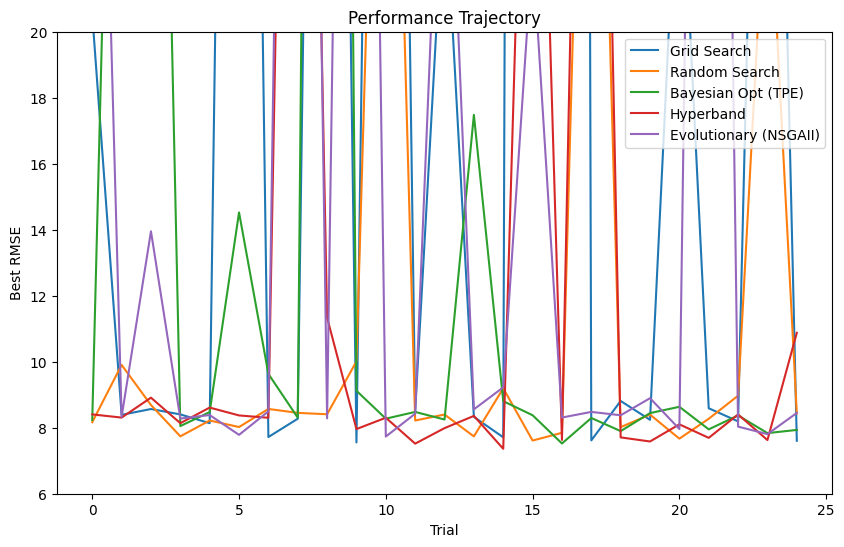

In [ ]:
# ------------------------------------------------------------------------------
# Truncate trajectories and performances for consistent plotting, as Optuna
# Grid Search runs all combinations while other methods are limited by
# n_trials (defaulting to 25).
# ------------------------------------------------------------------------------

N_TRIALS = 25

plt.figure(figsize=(10, 6))
plt.ylim([6, 20])
plt.plot(results["Grid_traj"][:N_TRIALS], label="Grid Search")
plt.plot(results["Random_traj"][:N_TRIALS], label="Random Search")
plt.plot(results["Bayes_traj"][:N_TRIALS], label="Bayesian Opt (TPE)")
plt.plot(results["Hyperband_traj"][:N_TRIALS], label="Hyperband")
plt.plot(results["Evolutionary_traj"][:N_TRIALS], label="Evolutionary (NSGAII)")

plt.xlabel("Trial")
plt.ylabel("Best RMSE")
plt.title("Performance Trajectory")
plt.legend()
plt.show()

# ------------------------------------------------------------------------------
# Changes to the evaluation class must be made if you want the 'elapsed_time'
# trajectories.
# For now 'grid_perf' returns only the best trial performance time.
# ------------------------------------------------------------------------------

# plt.figure(figsize=(10, 6))
# plt.plot(results["Grid_perf"][:N_TRIALS], label="Grid Search")
# plt.plot(results["Random_perf"][:N_TRIALS], label="Random Search")
# plt.plot(results["Bayes_perf"][:N_TRIALS], label="Bayesian Opt (TPE)")
# plt.plot(results["Hyperband_perf"][:N_TRIALS], label="Hyperband")
# plt.plot(results["Evolutionary_perf"][:N_TRIALS], label="Evolutionary (NSGAII)")

# plt.xlabel("Trial")
# plt.ylabel("Elapsed Time (s)")
# plt.title("Elapsed Time per Trial")
# plt.legend()
# plt.show()

In [ ]:
table = pd.DataFrame({
    "Method": ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"],
    "Best RMSE": [results["Grid_met"]["RMSE"], results["Random_met"]["RMSE"], results["Bayes_met"]["RMSE"], results["Hyperband_met"]["RMSE"], results["Evolutionary_met"]["RMSE"]],
    "MAE": [results["Grid_met"]["MAE"], results["Random_met"]["MAE"], results["Bayes_met"]["MAE"], results["Hyperband_met"]["MAE"], results["Evolutionary_met"]["MAE"]],
    "R2": [results["Grid_met"]["R2"], results["Random_met"]["R2"], results["Bayes_met"]["R2"], results["Hyperband_met"]["R2"], results["Evolutionary_met"]["R2"]],
    "Epochs":  [results["Grid_met"]["epochs"], results["Random_met"]["epochs"], results["Bayes_met"]["epochs"], results["Hyperband_met"]["epochs"], results["Evolutionary_met"]["epochs"]],
    "RunTime": [results["Grid_met"]["runtime"], results["Random_met"]["runtime"], results["Bayes_met"]["runtime"], results["Hyperband_met"]["runtime"], results["Evolutionary_met"]["runtime"]],
    "Best Params": [
        results["Grid"], results["Random"], results["Bayes"], results["Hyperband"], results["Evolutionary"]
    ]
})

print(table)
table.to_latex(index=False)

         Method  Best RMSE       MAE        R2  Epochs    RunTime  \
0          Grid   7.554451  5.913177  0.886688     100  64.752052   
1        Random   7.611637  5.966651  0.884966      25   6.066195   
2         Bayes   7.522510  5.857005  0.887644      52  33.684286   
3     Hyperband   7.361667  5.747454  0.892398      74  16.499175   
4  Evolutionary   7.732611  6.141984  0.881280      28   6.339774   

                                         Best Params  
0  {'lr': 0.001, 'momentum': 0.7, 'hidden_size': ...  
1  {'lr': 0.032084638483200374, 'momentum': 0.918...  
2  {'lr': 0.007993569715127505, 'momentum': 0.922...  
3  {'lr': 0.01067285461914955, 'momentum': 0.9373...  
4  {'lr': 0.01487408755820598, 'momentum': 0.9489...  


"\\begin{tabular}{lrrrrrl}\n\\toprule\nMethod & Best RMSE & MAE & R2 & Epochs & RunTime & Best Params \\\\\n\\midrule\nGrid & 7.554451 & 5.913177 & 0.886688 & 100 & 64.752052 & {'lr': 0.001, 'momentum': 0.7, 'hidden_size': 64, 'weight_decay': 0.01, 'batch_size': 16} \\\\\nRandom & 7.611637 & 5.966651 & 0.884966 & 25 & 6.066195 & {'lr': 0.032084638483200374, 'momentum': 0.9183928505392102, 'hidden_size': 8, 'weight_decay': 7.716847719280878e-05, 'batch_size': 64} \\\\\nBayes & 7.522510 & 5.857005 & 0.887644 & 52 & 33.684286 & {'lr': 0.007993569715127505, 'momentum': 0.9220801181400033, 'hidden_size': 8, 'weight_decay': 0.00668348184684264, 'batch_size': 16} \\\\\nHyperband & 7.361667 & 5.747454 & 0.892398 & 74 & 16.499175 & {'lr': 0.01067285461914955, 'momentum': 0.9373390496116293, 'hidden_size': 32, 'weight_decay': 0.0011520037410809015, 'batch_size': 64} \\\\\nEvolutionary & 7.732611 & 6.141984 & 0.881280 & 28 & 6.339774 & {'lr': 0.01487408755820598, 'momentum': 0.9489977724445942, '

--------------------------------------------------------------------------------
#**Everything together** - Reduction Techniques $\times$ Optimizers $\times$ Hyper-parameters
--------------------------------------------------------------------------------


In [ ]:
from tqdm import tqdm

results = {}

opt = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

features = {
    "raw": (Xtr, Xte),
    "kmeans": kmeans_features(Xtr, Xte, n_clusters=2)[:2],
    "pca": pca_features(Xtr, Xte, var_threshold=0.95)[:2],
    "autoencoder": autoencoder_features(Xtr, Xte, ytr, epochs=100, lr=1e-2)
}

def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    elif isinstance(x, np.ndarray):
        return torch.from_numpy(x).float()
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

# Convert all features safely
for key, (Xtr_feat, Xte_feat) in features.items():
    features[key] = (
        to_tensor(Xtr_feat),
        to_tensor(Xte_feat)
    )

total_steps = len(features) * len(opt)

with tqdm(total=total_steps, desc="Running experiments") as pbar:

    for feat_name, (Xtr_feat, Xte_feat) in features.items():
        results[feat_name] = {}

        for opt_name in opt:
            results[feat_name][opt_name] = {}  # Create sub-dict for each optimizer

            # Baselines
            grid_hp, grid_rmse, grid_traj, grid_loss, grid_met = run_optuna_grid_search(opt_name=opt_name, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=5)

            results["Grid"] = grid_hp
            results["Grid_rmse"] = grid_rmse
            results["Grid_traj"] = grid_traj
            results["Grid_loss"] = grid_loss
            results["Grid_met"] = grid_met

            rand_hp, rand_rmse, rand_traj, rand_loss, rand_met = run_optuna_random_search(opt_name=opt_name, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=5)

            results["Random"] = rand_hp
            results["Random_rmse"] = rand_rmse
            results["Random_traj"] = rand_traj
            results["Random_loss"] = rand_loss
            results["Random_met"] = rand_met

            # Advanced methods
            bo_hp, bo_rmse, bo_traj, bo_loss, bo_met = run_bayesian_optimization(opt_name=opt_name, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=5)

            results["Bayes"] = bo_hp
            results["Bayes_rmse"] = bo_rmse
            results["Bayes_traj"] = bo_traj
            results["Bayes_loss"] = bo_loss
            results["Bayes_met"] = bo_met

            hb_hp, hb_rmse, hb_traj, hb_loss, hb_met = run_hyperband(opt_name=opt_name, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=5)

            results["Hyperband"] = hb_hp
            results["Hyperband_rmse"] = hb_rmse
            results["Hyperband_traj"] = hb_traj
            results["Hyperband_loss"] = hb_loss
            results["Hyperband_met"] = hb_met

            ev_hp, ev_rmse, ev_traj, ev_loss, ev_met = run_evolutionary(opt_name=opt_name, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, n_trials=5)

            results["Evolutionary"] = ev_hp
            results["Evolutionary_rmse"] = ev_rmse
            results["Evolutionary_traj"] = ev_traj
            results["Evolutionary_loss"] = ev_loss
            results["Evolutionary_met"] = ev_met

            pbar.update(1)

Running experiments:   0%|          | 0/36 [00:00<?, ?it/s][I 2025-12-27 10:14:26,060] A new study created in memory with name: no-name-9560586d-6229-4211-915a-455b17539b58
[I 2025-12-27 10:14:31,887] Trial 0 finished with value: 8.355091173826246 and parameters: {'lr': 0.1, 'momentum': 0.8, 'hidden_size': 8, 'weight_decay': 0.01, 'batch_size': 32}. Best is trial 0 with value: 8.355091173826246.
[I 2025-12-27 10:14:52,588] Trial 1 finished with value: 9.964621714500051 and parameters: {'lr': 0.0001, 'momentum': 0.9, 'hidden_size': 64, 'weight_decay': 0.001, 'batch_size': 8}. Best is trial 0 with value: 8.355091173826246.
[I 2025-12-27 10:15:11,902] Trial 2 finished with value: 9.225092991305951 and parameters: {'lr': 0.0001, 'momentum': 0.9, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 8}. Best is trial 0 with value: 8.355091173826246.
[I 2025-12-27 10:15:32,585] Trial 3 finished with value: 8.344488332706085 and parameters: {'lr': 0.001, 'momentum': 0.99, 'hidden_size': 16, 

In [ ]:
features = ["raw", "pca", "autoencoder"]

hp_algos = ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]
algos = ["Grid", "Random", "TPE", "Hyperband", "NSGAII"]

for feat in features:
    plt.figure(figsize=(16,10))
    for op in opt:
        for i in range(len(hp_algos)):
            loss_curve = results[feat][op][hp_algos[i] + "_loss"]
            label_name = f"{op}+{algos[i]}"
            plt.plot(loss_curve, label=label_name)

    plt.ylim([0, 1])
    plt.title(f"Loss Curves per Epoch (Best Trial) for {feat.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fontsize=6, ncol=3)
    plt.grid(True)
    plt.show()

NameError: name 'opt' is not defined

<Figure size 1600x1000 with 0 Axes>

In [ ]:
def compact_params(hp_dict):
    # Convert long dict to short string, rounding floats
    if hp_dict is None:
        return ""
    return ", ".join(f"{k}={round(v, 4) if isinstance(v, float) else v}" for k, v in hp_dict.items())

rows = []

for feat_name, feat_dict in results.items():
    for opt_name, opt_dict in feat_dict.items():
        for algo in ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]:
          time = opt_dict.get(f"{algo}_perf", None)
          met = opt_dict.get(f"{algo}_met", None)
          best_hp = opt_dict.get(algo, None)
          if met is not None:
              rows.append({
                  "Feature": feat_name,
                  "Optimizer": opt_name,
                  "HP Algorithm": algo,
                  "Accuracy": round(met.get("acc", 0), 4),
                  "Precision": round(met.get("prec", 0), 4),
                  "Recall": round(met.get("rec", 0), 4),
                  "F1": round(met.get("f1", 0), 4),
                  "AUC": round(met.get("auc", 0), 4),
                  "Epochs": met.get("epochs", 0),
                  "Run-Time": round(time, 4),
                  "Best Params": compact_params(best_hp)
                })

table_clean = pd.DataFrame(rows)

# Export to LaTeX
latex_code = table_clean.to_latex(index=False, longtable=True)
print(latex_code)

\begin{longtable}{}
\toprule
\midrule
\endfirsthead
\toprule
\midrule
\endhead
\midrule
\multicolumn{0}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\end{longtable}



<details open>
<summary style="font-size:26px; font-weight:600;">
Fuzzy Rules Model
</summary>

---

## Motivation
This section implements a fuzzy rule-based control system to complement the
MLP baseline with interpretable decision rules.

The fuzzy system combines predicted activity levels with environmental
visibility conditions to determine the appropriate lighting intensity.

---

</details>

## 1. Visibility Estimation

Visibility is not directly available in the dataset.
It is estimated using contextual information such as:
- weather conditions,
- time of day (hour),
- ambient light level.

The resulting visibility score is normalized to the range [0, 1].


In [ ]:
!pip -q install scikit-fuzzy


In [ ]:
# Robustly extract hour information from the dataset.
# Supports 'hour', 'Hour', 'timestamp', or 'datetime' columns.
# Used to split behavior into day vs night.


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def extract_hour(df):
    if "hour" in df.columns:
        return df["hour"].to_numpy()
    if "Hour" in df.columns:
        return df["Hour"].to_numpy()
    if "timestamp" in df.columns:
        return pd.to_datetime(df["timestamp"]).dt.hour.to_numpy()
    if "datetime" in df.columns:
        return pd.to_datetime(df["datetime"]).dt.hour.to_numpy()
    raise ValueError("No hour/Hour/timestamp/datetime column found")

def metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


In [ ]:
# Convert raw activity-related features into a normalized activity score [0,1].
# This represents how active the street environment is.
# Used as fuzzy input variable 'activity'.


target = "adjusted_light_intensity"

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

y_tr = df_train[target].astype(float).to_numpy()
y_te = df_test[target].astype(float).to_numpy()

X_tr = df_train.drop(columns=[target])
X_te = df_test.drop(columns=[target])

print("Train:", X_tr.shape, "Test:", X_te.shape)


Train: (9600, 30) Test: (2400, 30)


In [ ]:
# Compute normalized visibility score [0,1].
# Combines ambient light (lux) and day/night information.
# Used as fuzzy input variable 'visibility'.


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor

num_cols = X_tr.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_tr.columns if c not in num_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=15,
    random_state=42
)

mlp_model = Pipeline([
    ("pre", pre),
    ("mlp", mlp),
])

mlp_model


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ambient_light_lux',
                                                   'motion_detected',
                                                   'temperature_celsius',
                                                   'occupancy_count',
                                                   'special_event_flag',
                                                   'energy_price_per_kwh',
                                                   'prev_hour_energy_usage_kwh',
                                                   'traffic_density',
                                                   'avg_pedestrian_speed',
                                                   'ene...
                                                   'zone_id_6', 'zone_id_7',
                                                   'zone_id_8', 'zone_id_9',
                                                   'zone_id_10', 'zone_id_11',
                                                   'zone_id_12',
                                                   'weather_condition_Cloudy',
                                                   'weather_condition_Foggy',
                                                   'weather_condition_Rainy',
                                                   'traffic_density_bin',
                                                   'day_period'])])),
                ('mlp',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(128, 64),
                              max_iter=500, n_iter_no_change=15,
                              random_state=42, validation_fraction=0.15))])

In [ ]:
# Define fuzzy variables (activity, visibility, lighting).
# Define membership functions (low / medium / high).
# Define a complete rule base covering the whole input space.
# Output is normalized lighting intensity in [0,1].


mlp_model.fit(X_tr, y_tr)

yhat_mlp_te = mlp_model.predict(X_te)

rmse, mae, r2 = metrics(y_te, yhat_mlp_te)
print(f"MLP(test): RMSE ≈ {rmse:.2f}, MAE ≈ {mae:.2f}, R² ≈ {r2:.3f}")


MLP(test): RMSE ≈ 7.47, MAE ≈ 5.81, R² ≈ 0.889


In [ ]:
#Helper functions (hour extraction + metric formatting)
#Compute activity score from dataset (normalized to [0,1])

import numpy as np
import pandas as pd

import skfuzzy as fuzz
from skfuzzy import control as ctrl

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



def extract_hour(df: pd.DataFrame) -> np.ndarray:
    if "hour" in df.columns:
        return df["hour"].to_numpy()
    if "Hour" in df.columns:
        return df["Hour"].to_numpy()
    if "timestamp" in df.columns:
        return pd.to_datetime(df["timestamp"]).dt.hour.to_numpy()
    if "datetime" in df.columns:
        return pd.to_datetime(df["datetime"]).dt.hour.to_numpy()
    raise ValueError("No hour/Hour/timestamp/datetime column found")

def compute_activity_score(df: pd.DataFrame) -> np.ndarray:
    if "occupancy_count" in df.columns:
        occ = df["occupancy_count"].to_numpy(dtype=float)
    elif "occupancy" in df.columns:
        occ = df["occupancy"].to_numpy(dtype=float)
    else:
        raise ValueError("No occupancy_count/occupancy column found")

    p5, p95 = np.percentile(occ, 5), np.percentile(occ, 95)
    return np.clip((occ - p5) / (p95 - p5 + 1e-8), 0, 1)

def compute_visibility_score_weighted(df: pd.DataFrame, w_lux=0.4, w_day=0.6) -> np.ndarray:
    hour = extract_hour(df)
    is_day = ((hour >= 7) & (hour < 19)).astype(float)

    if "ambient_light_lux" in df.columns:
        lux = df["ambient_light_lux"].to_numpy(dtype=float)
    elif "ambient_light" in df.columns:
        lux = df["ambient_light"].to_numpy(dtype=float)
    else:
        lux = None

    if lux is None:
        lux_norm = is_day
    else:
        p5, p95 = np.percentile(lux, 5), np.percentile(lux, 95)
        lux_norm = np.clip((lux - p5) / (p95 - p5 + 1e-8), 0, 1)

    v = w_lux * lux_norm + w_day * is_day
    return np.clip(v, 0, 1)

def build_fuzzy_system():
    u = np.linspace(0, 1, 101)

    activity = ctrl.Antecedent(u, "activity")
    visibility = ctrl.Antecedent(u, "visibility")
    lighting = ctrl.Consequent(u, "lighting")

    activity["low"]  = fuzz.trimf(u, [0.0, 0.0, 0.5])
    activity["med"]  = fuzz.trimf(u, [0.2, 0.5, 0.8])
    activity["high"] = fuzz.trimf(u, [0.5, 1.0, 1.0])

    visibility["poor"]   = fuzz.trimf(u, [0.0, 0.0, 0.5])
    visibility["normal"] = fuzz.trimf(u, [0.2, 0.5, 0.8])
    visibility["good"]   = fuzz.trimf(u, [0.5, 1.0, 1.0])

    lighting["dim"]    = fuzz.trimf(u, [0.0, 0.0, 0.5])
    lighting["normal"] = fuzz.trimf(u, [0.2, 0.5, 0.8])
    lighting["full"]   = fuzz.trimf(u, [0.5, 1.0, 1.0])

    rules = [
        ctrl.Rule(activity["high"], lighting["full"]),
        ctrl.Rule(activity["med"] & visibility["poor"], lighting["full"]),
        ctrl.Rule(activity["med"] & visibility["normal"], lighting["normal"]),
        ctrl.Rule(activity["low"] & visibility["good"], lighting["dim"]),

        ctrl.Rule(activity["low"] & visibility["poor"], lighting["normal"]),
        ctrl.Rule(activity["low"] & visibility["normal"], lighting["dim"]),
        ctrl.Rule(activity["med"] & visibility["good"], lighting["normal"]),
        ctrl.Rule(activity["high"] & visibility["good"], lighting["full"]),
        ctrl.Rule(activity["high"] & visibility["poor"], lighting["full"]),
    ]

    return ctrl.ControlSystem(rules)

SYSTEM = build_fuzzy_system()

def fuzzy_predict_z(df_part: pd.DataFrame, w_lux=0.4, w_day=0.6) -> np.ndarray:
    a = compute_activity_score(df_part)
    v = compute_visibility_score_weighted(df_part, w_lux=w_lux, w_day=w_day)

    sim = ctrl.ControlSystemSimulation(SYSTEM)
    z = np.zeros(len(df_part), dtype=float)

    for i in range(len(df_part)):
        sim.input["activity"] = float(a[i])
        sim.input["visibility"] = float(v[i])
        sim.compute()
        z[i] = float(sim.output["lighting"])
    return z

def metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


In [ ]:
def fuzzy_predict_target_daynight(df_train, df_part, w_lux=0.4, w_day=0.6):
    z_tr = fuzzy_predict_z(df_train, w_lux=w_lux, w_day=w_day)
    z_te = fuzzy_predict_z(df_part,  w_lux=w_lux, w_day=w_day)

    y_tr = df_train[target].astype(float).to_numpy()

    h_tr = extract_hour(df_train)
    h_te = extract_hour(df_part)

    is_day_tr = (h_tr >= 7) & (h_tr < 19)
    is_day_te = (h_te >= 7) & (h_te < 19)

    # osobna kalibracja dla day i night: y ≈ alpha + beta*z
    Xd = np.vstack([np.ones_like(z_tr[is_day_tr]), z_tr[is_day_tr]]).T
    alpha_d, beta_d = np.linalg.lstsq(Xd, y_tr[is_day_tr], rcond=None)[0]

    Xn = np.vstack([np.ones_like(z_tr[~is_day_tr]), z_tr[~is_day_tr]]).T
    alpha_n, beta_n = np.linalg.lstsq(Xn, y_tr[~is_day_tr], rcond=None)[0]

    yhat = np.zeros(len(df_part), dtype=float)
    yhat[is_day_te]  = alpha_d + beta_d * z_te[is_day_te]
    yhat[~is_day_te] = alpha_n + beta_n * z_te[~is_day_te]

    return yhat, (float(alpha_d), float(beta_d), float(alpha_n), float(beta_n))

yhat_fuzzy_te, calib = fuzzy_predict_target_daynight(df_train, df_test)
rmse_f, mae_f, r2_f = metrics(y_te, yhat_fuzzy_te)

print(f"Fuzzy(test): RMSE ≈ {rmse_f:.2f}, MAE ≈ {mae_f:.2f}, R² ≈ {r2_f:.3f}")
print("Calib(day alpha,beta ; night alpha,beta):", calib)


Fuzzy(test): RMSE ≈ 19.31, MAE ≈ 15.68, R² ≈ 0.259
Calib(day alpha,beta ; night alpha,beta): (39.80571069441043, 35.00104736264035, 51.21976817251337, 37.889386938165465)


In [ ]:
yhat_mlp_tr = mlp_model.predict(X_tr)
yhat_fuzzy_tr, _ = fuzzy_predict_target_daynight(df_train, df_train)

dev_tr = np.abs(yhat_mlp_tr - yhat_fuzzy_tr)
dev_te = np.abs(yhat_mlp_te - yhat_fuzzy_te)

thr = np.percentile(dev_tr, 90)
is_out_te = dev_te > thr

print(f"Deviation threshold (p90 train): {thr:.2f}")
print(f"Outliers in test: {is_out_te.mean()*100:.2f}%")


Deviation threshold (p90 train): 29.31
Outliers in test: 9.67%


In [ ]:
def correct_mlp_with_fuzzy(y_mlp, y_fuzzy, dev, thr, w_max=0.7):
    # dev<=thr -> w≈0, dev much bigger -> w do w_max
    w = np.clip((dev - thr) / (thr + 1e-8), 0, 1) * w_max
    return (1 - w) * y_mlp + w * y_fuzzy, w

yhat_corr_te, w_te = correct_mlp_with_fuzzy(yhat_mlp_te, yhat_fuzzy_te, dev_te, thr, w_max=0.7)


In [ ]:
# Evaluate fuzzy model performance on test set.
# Metrics remember:
# - RMSE / MAE are in original units
# - R² measures how much variance is explained
# Also compute percentage-based errors (nRMSE, nMAE, MAPE).


rmse0, mae0, r20 = metrics(y_te, yhat_mlp_te)
rmse1, mae1, r21 = metrics(y_te, yhat_corr_te)

print(f"MLP(test):        RMSE ≈ {rmse0:.2f}, MAE ≈ {mae0:.2f}, R² ≈ {r20:.3f}")
print(f"MLP+Fuzzy(test):  RMSE ≈ {rmse1:.2f}, MAE ≈ {mae1:.2f}, R² ≈ {r21:.3f}")

# how it looks on outliners
if is_out_te.any():
    rmse_o0, mae_o0, r2_o0 = metrics(y_te[is_out_te], yhat_mlp_te[is_out_te])
    rmse_o1, mae_o1, r2_o1 = metrics(y_te[is_out_te], yhat_corr_te[is_out_te])
    print()
    print(f"Outliers only ({is_out_te.mean()*100:.2f}%):")
    print(f"  MLP:       RMSE ≈ {rmse_o0:.2f}, MAE ≈ {mae_o0:.2f}, R² ≈ {r2_o0:.3f}")
    print(f"  MLP+Fuzzy: RMSE ≈ {rmse_o1:.2f}, MAE ≈ {mae_o1:.2f}, R² ≈ {r2_o1:.3f}")


MLP(test):        RMSE ≈ 7.47, MAE ≈ 5.81, R² ≈ 0.889
MLP+Fuzzy(test):  RMSE ≈ 8.16, MAE ≈ 6.15, R² ≈ 0.868

Outliers only (9.67%):
  MLP:       RMSE ≈ 7.72, MAE ≈ 6.06, R² ≈ 0.928
  MLP+Fuzzy: RMSE ≈ 13.12, MAE ≈ 9.57, R² ≈ 0.793


In [ ]:
# Compare fuzzy model against:
# 1) Global mean baseline
# 2) Hour-based mean baseline
# Shows that fuzzy logic improves over naive baselines,
# but is still limited by input information.


print("Final comparison:")
print(f"MLP:       RMSE≈{rmse0:.2f}, MAE≈{mae0:.2f}, R²≈{r20:.3f}")
print(f"MLP+Fuzzy: RMSE≈{rmse1:.2f}, MAE≈{mae1:.2f}, R²≈{r21:.3f}")
print(f"Flagged as outliers: {is_out_te.mean()*100:.2f}% (threshold p90 train deviation)")


Final comparison:
MLP:       RMSE≈7.47, MAE≈5.81, R²≈0.889
MLP+Fuzzy: RMSE≈8.16, MAE≈6.15, R²≈0.868
Flagged as outliers: 9.67% (threshold p90 train deviation)
